In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")
import datetime as dt
from scipy import stats

In [2]:
train_data = pd.read_csv('C:/Users/ISR1/Documents/nyc/train.csv')
test_data = pd.read_csv('C:/Users/ISR1/Documents/nyc/test.csv')

In [8]:
train_data.shape

(1458644, 11)

In [9]:
test_data.shape

(625134, 9)

# 1. Exploratory Data Analysis:

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
print(train_data.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [7]:
train_data['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

## 1.1. Before removing outliers

In [11]:
print("The median trip duration is %.3f minutes" % np.round(np.median(train_data['trip_duration'])/60,3))
print("The mean trip duration is %.3f minutes" % np.round(np.mean(train_data['trip_duration'])/60,3))
print("The shortest trip duration is %.3f seconds" % np.round(np.min(train_data['trip_duration']),3))
print("The longest trip duration is %.3f minutes" % np.round(np.max(train_data['trip_duration'])/60,3))

The median trip duration is 11.033 minutes
The mean trip duration is 15.992 minutes
The shortest trip duration is 1.000 seconds
The longest trip duration is 58771.367 minutes


### Observation:

1) A total of 11 features of which 3 are integers, 4 are floats and 4 are objects.

2) The average trip duration is 15.992 minutes and the median duration is 11.033 minutes. (The data is provided in seconds)

3) The minimumtrip duration is 1 second and the maximum trip duration is 979.523 hours. Both these values look extreme. They might be outliers.

## 1.2. Removing outliers - trip duration

In [13]:
train_z = np.abs(stats.zscore(train_data['trip_duration']))
print(train_z)

0          0.096324
1          0.056610
2          0.222343
3          0.101289
4          0.100143
             ...   
1458639    0.034653
1458640    0.058138
1458641    0.037326
1458642    0.111981
1458643    0.145394
Name: trip_duration, Length: 1458644, dtype: float64


In [14]:
train_t = np.where(train_z > 3)
print(train_t)
print(len(train_t[0]))

(array([    531,    1134,    1865, ..., 1457207, 1457752, 1458076],
      dtype=int64),)
2073


In [15]:
train_data.drop(train_t[0],inplace = True)

In [16]:
train_data.shape

(1456571, 11)

## 1.3. After removing outliers

In [17]:
print("The median trip duration is %.3f minutes" % np.round(np.median(train_data['trip_duration'])/60,3))
print("The mean trip duration is %.3f minutes" % np.round(np.mean(train_data['trip_duration'])/60,3))
print("The shortest trip duration is %.3f seconds" % np.round(np.min(train_data['trip_duration']),3))
print("The longest trip duration is %.3f minutes" % np.round(np.max(train_data['trip_duration'])/60,3))

The median trip duration is 11.033 minutes
The mean trip duration is 13.952 minutes
The shortest trip duration is 1.000 seconds
The longest trip duration is 265.000 minutes


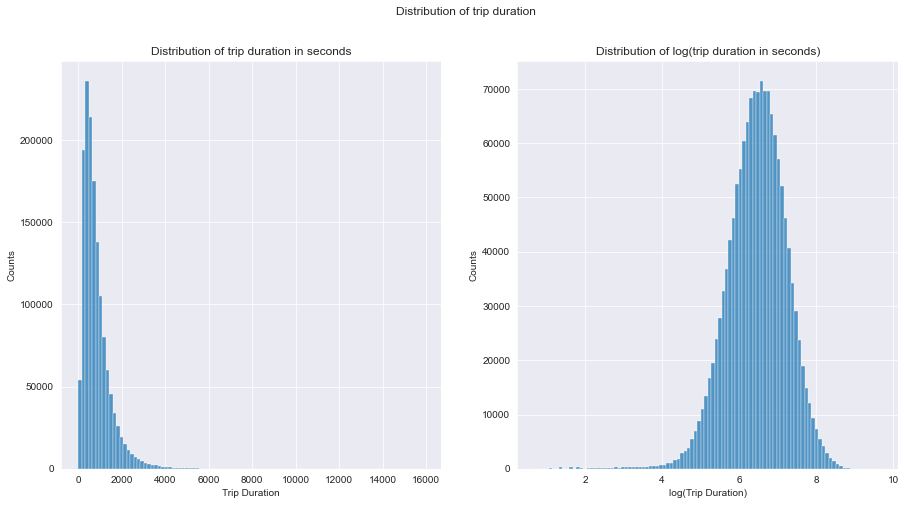

In [18]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of trip duration')
plt.subplot(1,2,1)
fig = sb.histplot(train_data['trip_duration'], bins=100)
fig.set(title = "Distribution of trip duration in seconds",xlabel='Trip Duration', ylabel='Counts')

plt.subplot(1,2,2)
fig = sb.histplot(np.log(train_data['trip_duration']+1), bins=100)
fig.set(title = "Distribution of log(trip duration in seconds)",xlabel='log(Trip Duration)', ylabel='Counts')

plt.show()

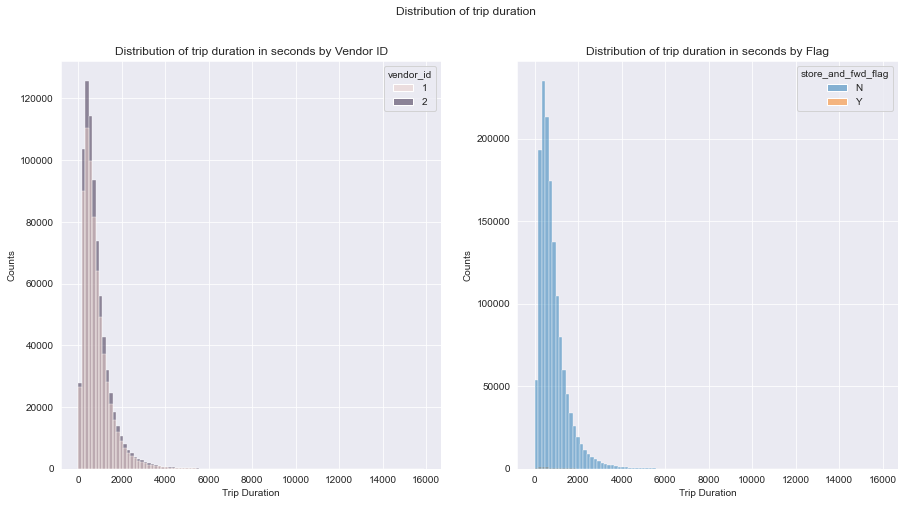

In [13]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of trip duration')
plt.subplot(1,2,1)
fig = sb.histplot(data = train_data,x = 'trip_duration',hue='vendor_id', bins=100)
fig.set(title = "Distribution of trip duration in seconds by Vendor ID",xlabel='Trip Duration', ylabel='Counts')

plt.subplot(1,2,2)
fig = sb.histplot(data = train_data,x = 'trip_duration',hue='store_and_fwd_flag',bins=100)
fig.set(title = "Distribution of trip duration in seconds by Flag",xlabel='Trip Duration', ylabel='Counts')

plt.show()

### Observation

1) The distribution of the trip_duration varible, without outlier removal gave bad plots. So we removed the outliers. Now the trip_duration looks to be skewed and not following the normal distribution.

2) So we convert into normal distribution using log transform.

3) Similar patterns were seen while plotting the distribution of trip_duration using Vendor ID and Flag.

In [19]:
def pdf_cdf_plots(data,variable,bins,plot_title,x_label,y_label='Probability'):
    counts, bins = np.histogram(train_data[variable],bins=bins,density=True)
    pdf = counts/sum(counts)
    cdf = np.cumsum(pdf)
    plt.title(plot_title)
    plt.plot(bins[1:],pdf[:],label='pdf')
    plt.xlabel(x_label)
    plt.plot(bins[1:],cdf[:],label='cdf')
    plt.ylabel(y_label)
    plt.legend(loc="upper left")
    plt.show()

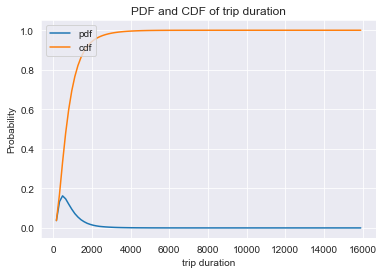

In [20]:
pdf_cdf_plots(train_data,'trip_duration',100,'PDF and CDF of trip duration',"trip duration")

### Observation:

1) More than ~90% of the trip duarations are less than or equal 2000 seconds

2) More than 99% of the trip duartions are less than or equal to 4000 seconds

## 1.4. Location Features:

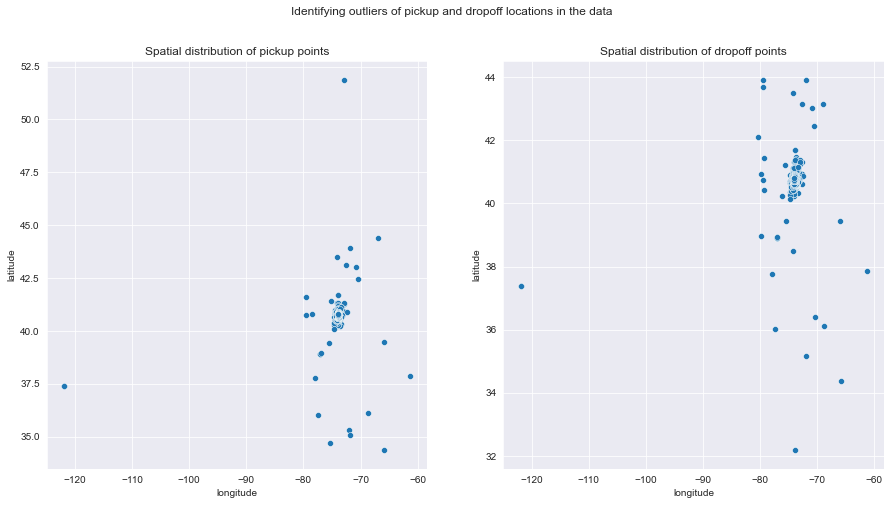

In [16]:
#plotting locations with outliers

plt.figure(figsize=(15,7.5))
plt.suptitle('Identifying outliers of pickup and dropoff locations in the data')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = train_data,x='pickup_longitude',y='pickup_latitude')
fig.set(title = "Spatial distribution of pickup points",xlabel='longitude', ylabel='latitude')

plt.subplot(1,2,2)
fig = sb.scatterplot(data = train_data,x='dropoff_longitude',y='dropoff_latitude')
fig.set(title = "Spatial distribution of dropoff points",xlabel='longitude', ylabel='latitude')

plt.show()

## 1.5. Removing outliers - location extents

In [23]:
train_data = train_data[(train_data["pickup_latitude"] <= 42.0) & (train_data["pickup_latitude"] >= 40.0)]
train_data = train_data[(train_data["pickup_longitude"] <= -72.0) & (train_data["pickup_longitude"] >= -75.0)]
train_data = train_data[(train_data["dropoff_latitude"] <= 42.0) & (train_data["dropoff_latitude"] >= 40.0)]
train_data = train_data[(train_data["dropoff_longitude"] <= -72.0) & (train_data["dropoff_longitude"] >= -75.0)]

In [21]:
test_data = test_data[(test_data["pickup_latitude"] <= 42.0) & (test_data["pickup_latitude"] >= 40.0)]
test_data = test_data[(test_data["pickup_longitude"] <= -72.0) & (test_data["pickup_longitude"] >= -75.0)]
test_data = test_data[(test_data["dropoff_latitude"] <= 42.0) & (test_data["dropoff_latitude"] >= 40.0)]
test_data = test_data[(test_data["dropoff_longitude"] <= -72.0) & (test_data["dropoff_longitude"] >= -75.0)]

In [24]:
train_data.shape

(1456535, 11)

In [22]:
test_data.shape

(625115, 9)

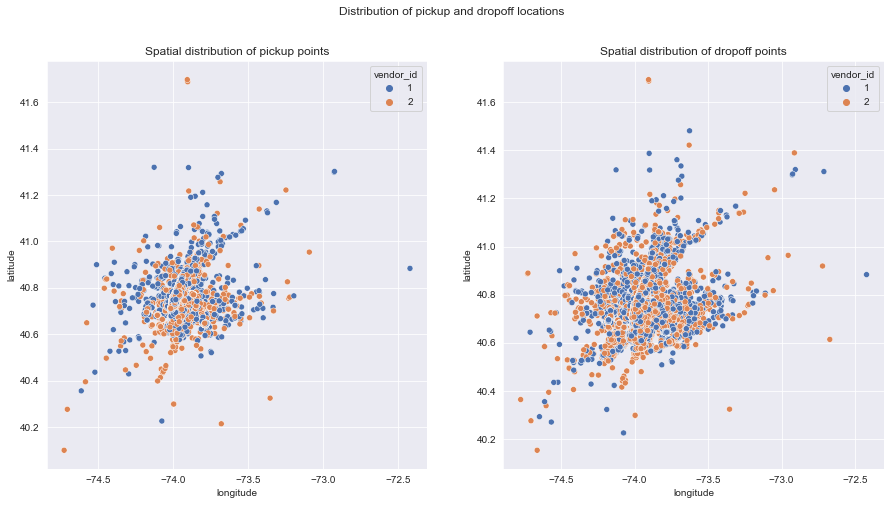

In [20]:
#plotting locations after removing outliers

plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of pickup and dropoff locations')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = data,x='pickup_longitude',y='pickup_latitude',hue='vendor_id',palette="deep")
fig.set(title = "Spatial distribution of pickup points",xlabel='longitude', ylabel='latitude')

plt.subplot(1,2,2)
fig = sb.scatterplot(data = data,x='dropoff_longitude',y='dropoff_latitude',hue='vendor_id',palette="deep")
fig.set(title = "Spatial distribution of dropoff points",xlabel='longitude', ylabel='latitude')

plt.show()

C:\Users\arunt\anaconda3\envs\gpu-enabled-spatial\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


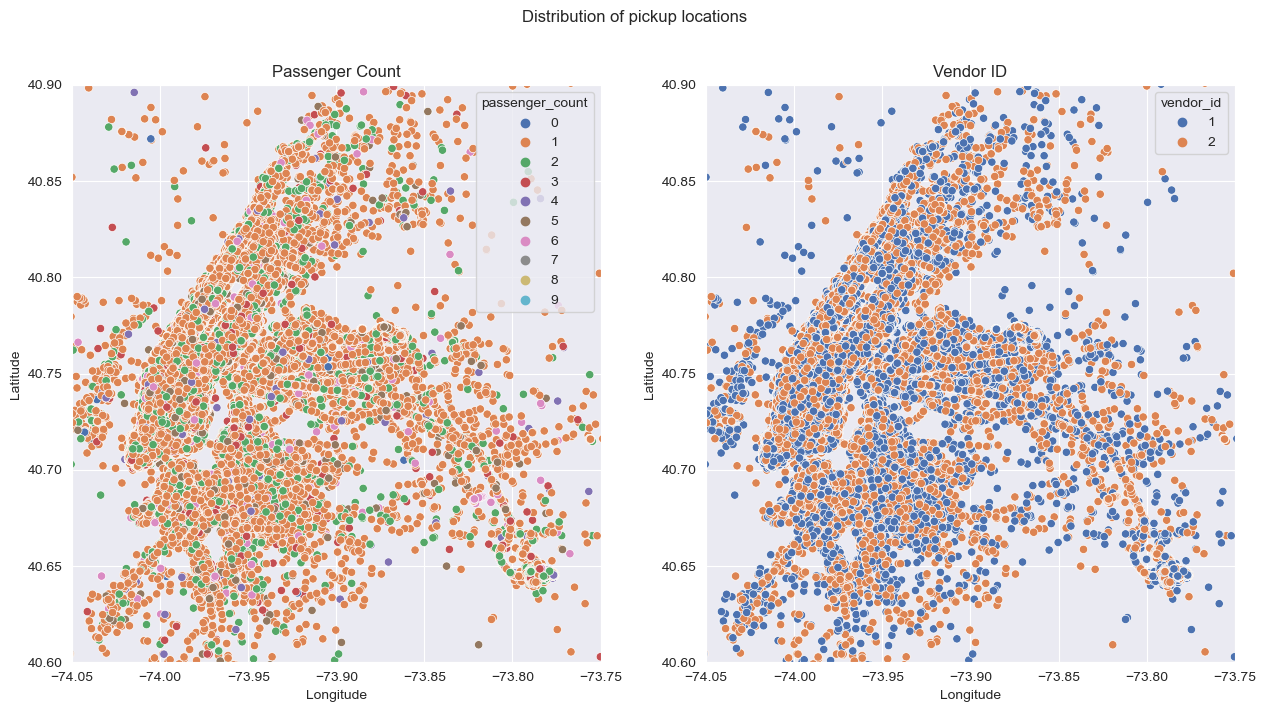

In [21]:
city_long_border = (-74.05, -73.75)
city_lat_border = (40.60, 40.90)

plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of pickup locations')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = train_data,x='pickup_longitude',y='pickup_latitude',hue='passenger_count',palette="deep",legend='auto')
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Passenger Count",xlabel="Longitude",ylabel="Latitude")

plt.subplot(1,2,2)
fig = sb.scatterplot(data = train_data,x='pickup_longitude',y='pickup_latitude',hue='vendor_id',palette="deep",legend='auto')
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Vendor ID",xlabel="Longitude",ylabel="Latitude")
plt.show()

C:\Users\arunt\anaconda3\envs\gpu-enabled-spatial\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


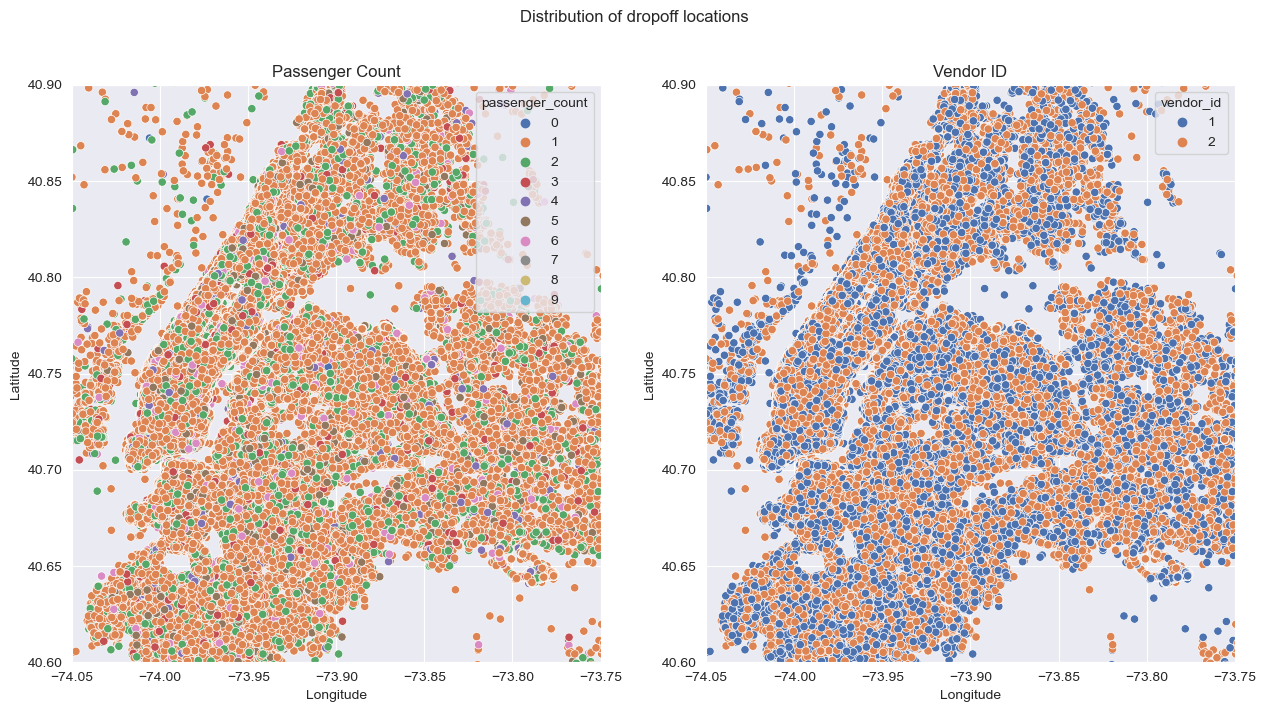

In [28]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of dropoff locations')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = train_data,x='dropoff_longitude',y='dropoff_latitude',hue='passenger_count',palette="deep",legend='auto')
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Passenger Count",xlabel="Longitude",ylabel="Latitude")

plt.subplot(1,2,2)
fig = sb.scatterplot(data = train_data,x='dropoff_longitude',y='dropoff_latitude',hue='vendor_id',palette="deep",legend='auto')
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Vendor ID",xlabel="Longitude",ylabel="Latitude")
plt.show()

### Observation:

1) Both the pickupp and dropoff locations are having a lot of outliers which can influence the prediction results.

2) After trying different bounding boxes, (40.0,-75.0) and (42.0,-72.0) were fixed as the bounding box to omit outliers.

3) It can be seen from the subset that majority of the passenger count <= 3 and very few is >3.

4) But no distinct pattern could be seen in the pickup locations by vendor ID.

5) Looks like the dropoff points are more widely spread (spatially) than the pickup points.

## 1.6. Store and Forward Flag feature:

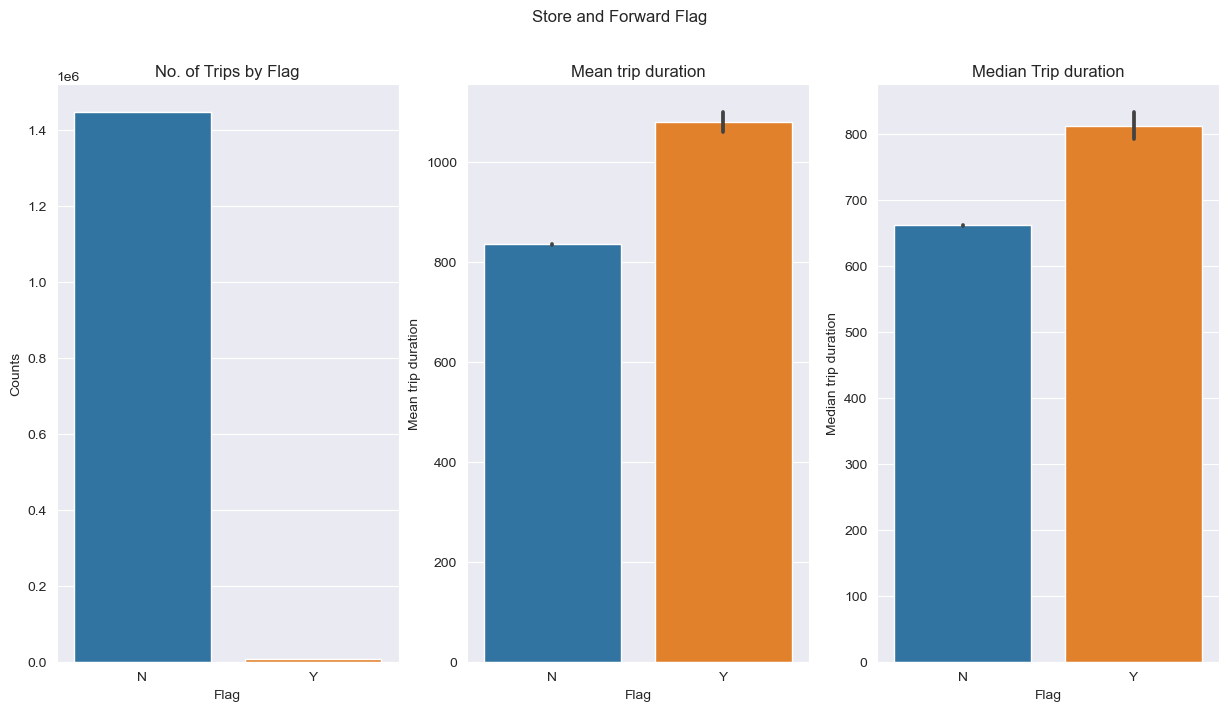

In [12]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Store and Forward Flag')

plt.subplot(1,3,1)
fig = sb.countplot(x = train_data['store_and_fwd_flag'])
fig.set(title = "No. of Trips by Flag",xlabel='Flag', ylabel='Counts')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['store_and_fwd_flag'],y=data['trip_duration'],estimator=np.mean)
fig.set(title = "Mean trip duration",xlabel='Flag', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['store_and_fwd_flag'],y=data['trip_duration'],estimator=np.median)
fig.set(title = "Median Trip duration",xlabel='Flag', ylabel='Median trip duration')
plt.show()

In [59]:
g_flag = train_data.groupby('store_and_fwd_flag')
g1 = g_flag.get_group('Y')
g1['trip_duration'].describe()

count    8045.000000
mean     1080.763331
std       925.645317
min         2.000000
25%       455.000000
50%       812.000000
75%      1400.000000
max      9984.000000
Name: trip_duration, dtype: float64

In [60]:
g2 = g_flag.get_group('N')
g2['trip_duration'].describe()

count    1.450599e+06
mean     9.588197e+02
std      5.251475e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.074000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

### Observation:

1) Only 8045 trips records are held in vehicle memory before sending to the vendor while the remaining 1.450599e+06 dont store.

2) The mean and median trip durations when flag is Y is ~1500 and ~800 seconds

3) The mean and median trip durations when flag is Y is ~800 and ~650 seconds

## 1.7. Vendor ID feature:

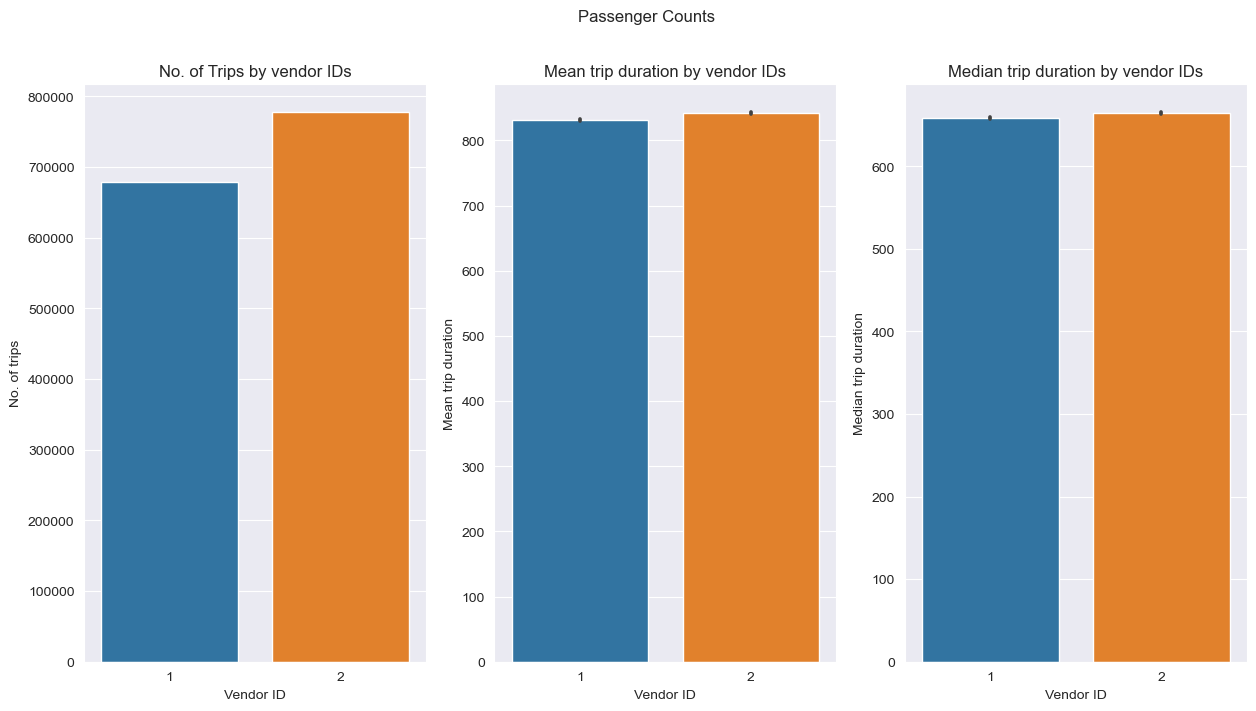

In [64]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Passenger Counts')
plt.subplot(1,3,1)
fig = sb.countplot(x = train_data['vendor_id'])
fig.set(title = "No. of Trips by vendor IDs",xlabel='Vendor ID', ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['vendor_id'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration by vendor IDs",xlabel='Vendor ID', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['vendor_id'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration by vendor IDs",xlabel='Vendor ID', ylabel='Median trip duration')
plt.show()

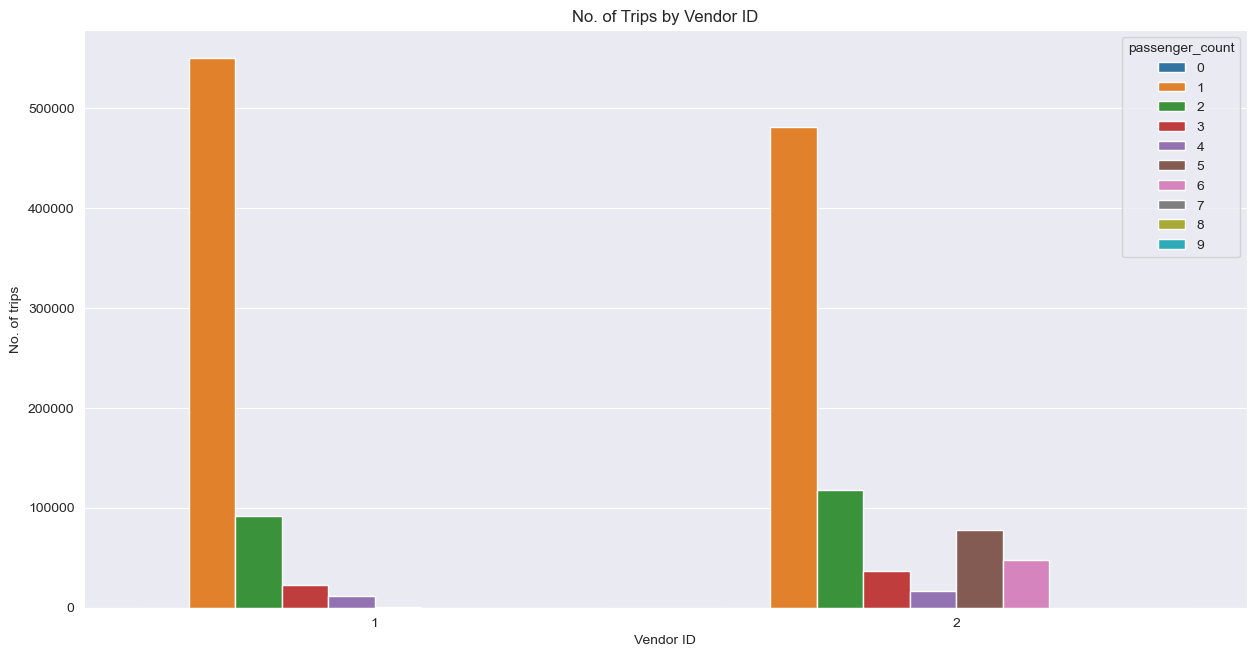

In [29]:
plt.figure(figsize=(15,7.5))
fig = sb.countplot(x = train_data['vendor_id'],hue=data['passenger_count'])
fig.set(title = "No. of Trips by Vendor ID",xlabel='Vendor ID', ylabel='No. of trips')
plt.show()

### Observation:

1) ~5 lakh trips are with 1 passenger only for both vendor IDs

2) ~1 lakh trips are with 2 passengers

3) Vendor 2 might have more of a special/different vehicle which might accomodate 5/6 passengers than Vendor 1

## 1.8. Passenger Counts feature:

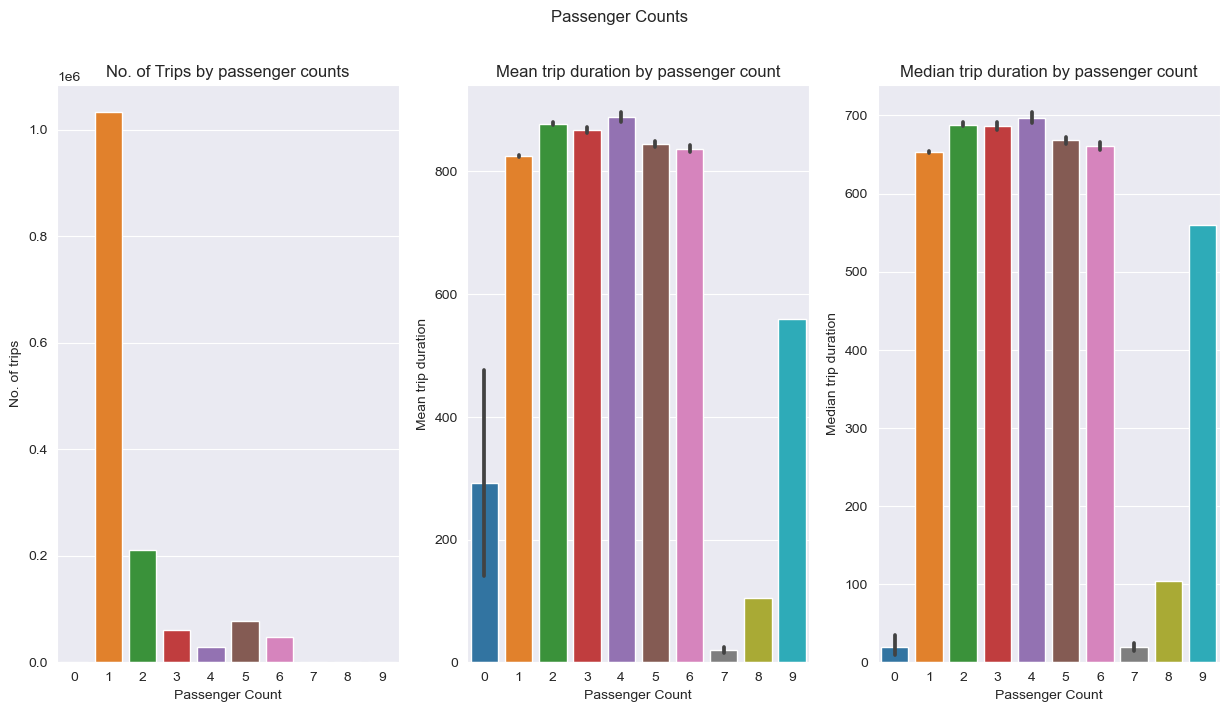

In [26]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Passenger Counts')
plt.subplot(1,3,1)
fig = sb.countplot(x = train_data['passenger_count'])
fig.set(title = "No. of Trips by passenger counts",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['passenger_count'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration by passenger count",xlabel='Passenger Count', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['passenger_count'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration by passenger count",xlabel='Passenger Count', ylabel='Median trip duration')
plt.show()

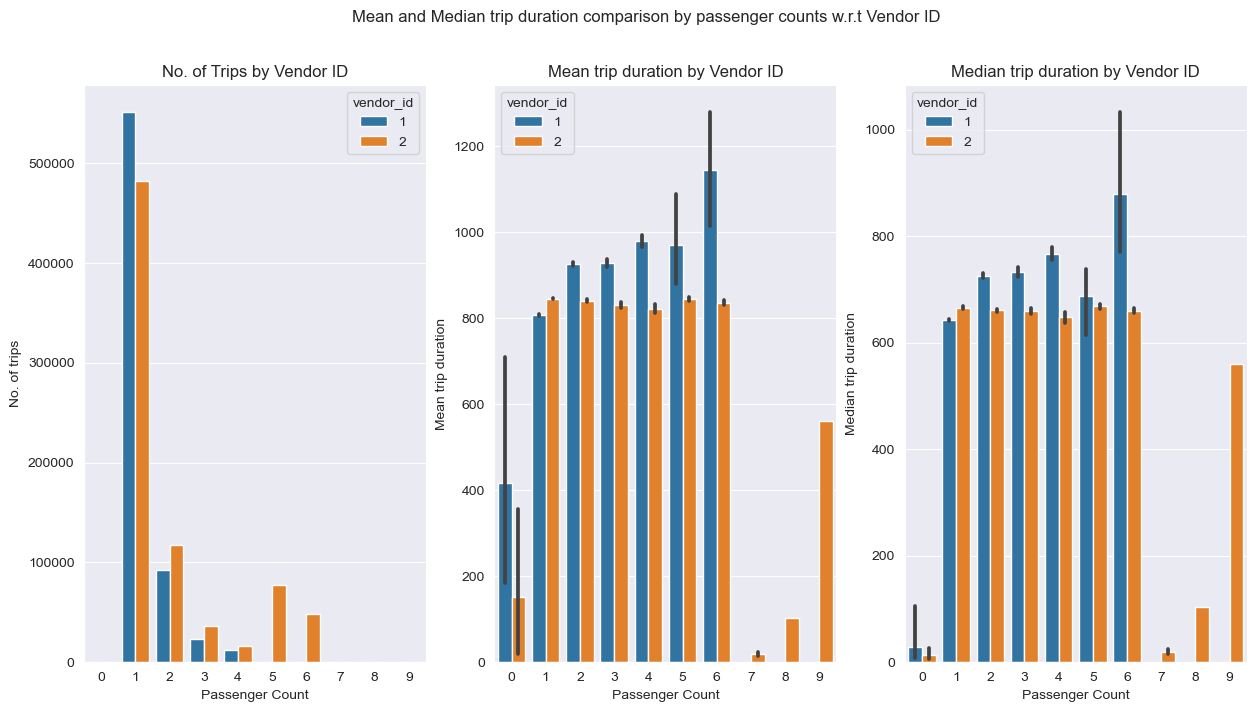

In [25]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Mean and Median trip duration comparison by passenger counts w.r.t Vendor ID')

plt.subplot(1,3,1)
fig = sb.countplot(x = train_data['passenger_count'],hue=data['vendor_id'])
fig.set(title = "No. of Trips by Vendor ID",xlabel='Passenger Count', ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(data=train_data, x="passenger_count", y='trip_duration',hue="vendor_id",estimator='mean')
fig.set(title = "Mean trip duration by Vendor ID",xlabel='Passenger Count',ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(data=train_data, x="passenger_count", y='trip_duration',hue="vendor_id",estimator='median')
fig.set(title = "Median trip duration by Vendor ID",xlabel='Passenger Count',ylabel='Median trip duration')
plt.show()

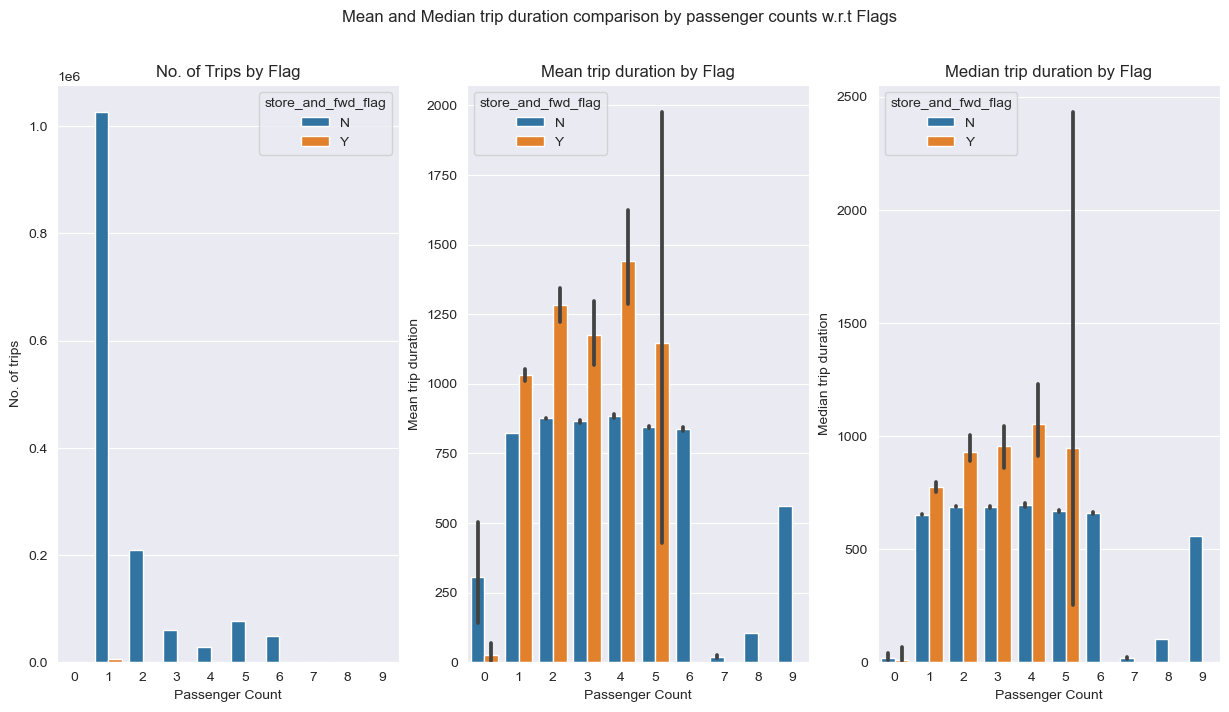

In [72]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Mean and Median trip duration comparison by passenger counts w.r.t Flags')
plt.subplot(1,3,1)
fig = sb.countplot(x = train_data['passenger_count'],hue=data['store_and_fwd_flag'])
fig.set(title = "No. of Trips by Flag",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(data=train_data, x="passenger_count", y='trip_duration',hue="store_and_fwd_flag",estimator='mean')
fig.set(title = "Mean trip duration by Flag",xlabel='Passenger Count',ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(data=train_data, x="passenger_count", y='trip_duration',hue="store_and_fwd_flag",estimator='median')
fig.set(title = "Median trip duration by Flag",xlabel='Passenger Count',ylabel='Median trip duration')
plt.show()

### Observation

1) More than ~10 lakh taxi rides are done by 1 passenger.

2) The mean and median trip durations are more than 800 seconds and 600 seconds for trips with 2 - 6 passengers, < 600 seconds for 9 passengers and ~ 100 seconds for 8 passengers

# 2. Feature Engineering

## 2.1. Date and Time features

In [25]:
train_data['pickup_datetime'] = pd.to_datetime(train_data["pickup_datetime"])
test_data['pickup_datetime'] = pd.to_datetime(test_data["pickup_datetime"])

In [26]:
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data['pickup_day'] = train_data['pickup_datetime'].dt.day
train_data['pickup_day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month
train_data['pickup_weekyear'] = train_data['pickup_datetime'].dt.week
#data['pickup_weekday'] = data['pickup_datetime'].dt.weekday must be removed. its a repetition of data

C:\Users\ISR1\AppData\Local\Temp/ipykernel_6512/1306851194.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_data['pickup_weekyear'] = train_data['pickup_datetime'].dt.week


In [27]:
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour
test_data['pickup_day'] = test_data['pickup_datetime'].dt.day
test_data['pickup_day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
test_data['pickup_month'] = test_data['pickup_datetime'].dt.month
test_data['pickup_weekyear'] = test_data['pickup_datetime'].dt.week

C:\Users\ISR1\AppData\Local\Temp/ipykernel_6512/2040098061.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_data['pickup_weekyear'] = test_data['pickup_datetime'].dt.week


In [28]:
train_data.shape

(1456535, 16)

In [29]:
test_data.shape

(625115, 14)

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456535 entries, 0 to 1458643
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1456535 non-null  object        
 1   vendor_id           1456535 non-null  int64         
 2   pickup_datetime     1456535 non-null  datetime64[ns]
 3   dropoff_datetime    1456535 non-null  object        
 4   passenger_count     1456535 non-null  int64         
 5   pickup_longitude    1456535 non-null  float64       
 6   pickup_latitude     1456535 non-null  float64       
 7   dropoff_longitude   1456535 non-null  float64       
 8   dropoff_latitude    1456535 non-null  float64       
 9   store_and_fwd_flag  1456535 non-null  object        
 10  trip_duration       1456535 non-null  int64         
 11  pickup_hour         1456535 non-null  int64         
 12  pickup_day          1456535 non-null  int64         
 13  pickup_day_o

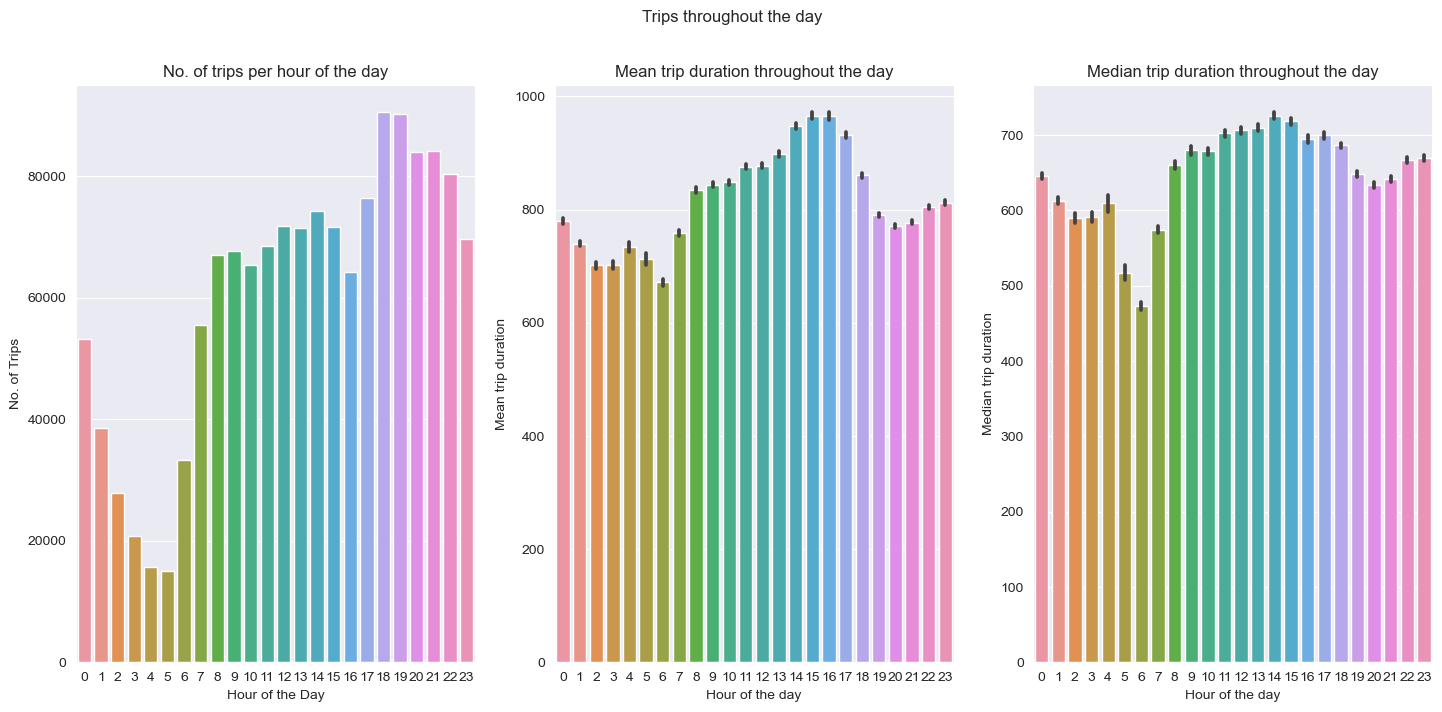

In [34]:
plt.figure(figsize=(17.5,7.5))
plt.suptitle('Trips throughout the day')
plt.subplot(1,3,1)
fig = sb.countplot(x=train_data["pickup_hour"])
fig.set(title = "No. of trips per hour of the day",xlabel='Hour of the Day', ylabel='No. of Trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['pickup_hour'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration throughout the day",xlabel='Hour of the day', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['pickup_hour'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration throughout the day",xlabel='Hour of the day', ylabel='Median trip duration')

plt.show()

### Observation

1) The no. of trips is the least during early morning 3 to 5 AM and reaches the peak during 6 to 7 PM.

2) The mean and median trip durations the least during early morning - 6 AM.

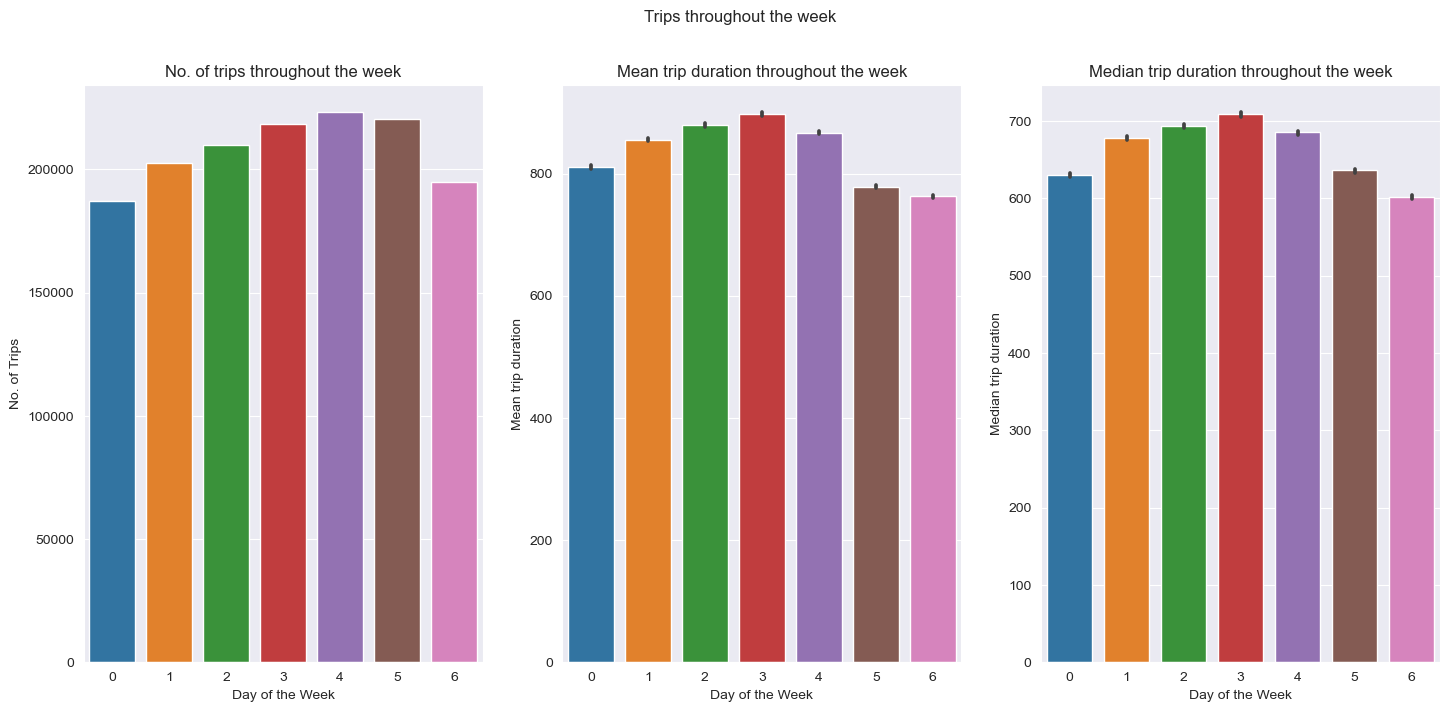

In [35]:
plt.figure(figsize=(17.5,7.5))
plt.suptitle('Trips throughout the week')
plt.subplot(1,3,1)
fig = sb.countplot(x=train_data["pickup_day_of_week"])
fig.set(title = "No. of trips throughout the week",xlabel='Day of the Week', ylabel='No. of Trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['pickup_day_of_week'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration throughout the week",xlabel='Day of the Week', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['pickup_day_of_week'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration throughout the week",xlabel='Day of the Week', ylabel='Median trip duration')
plt.show()

### Observation

1) The no. of trips are the least during sundays and saturdays

2) The mean and median trip durations are also the least during the weekends and higher during the week days.

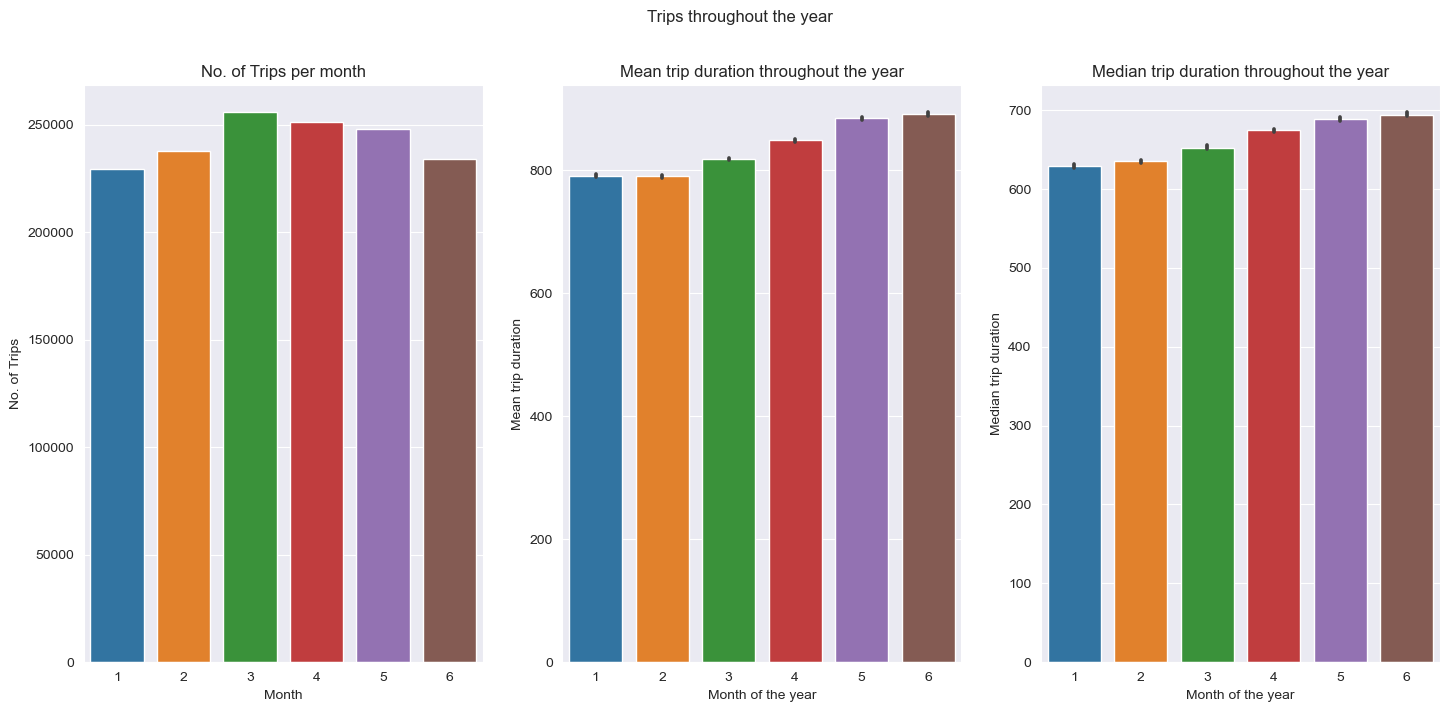

In [36]:
plt.figure(figsize=(17.5,7.5))
plt.suptitle('Trips throughout the year')
plt.subplot(1,3,1)
fig = sb.countplot(x=train_data["pickup_month"])
fig.set(title = "No. of Trips per month",xlabel='Month', ylabel='No. of Trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['pickup_month'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration throughout the year",xlabel='Month of the year', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['pickup_month'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration throughout the year",xlabel='Month of the year', ylabel='Median trip duration')
plt.show()

### Observation:

1) The no. of trips during March is the highest followed by April and May.

2) The mean and median trip durations are low during the beginning of the year - Jan, Feb and increases during April, May and June.

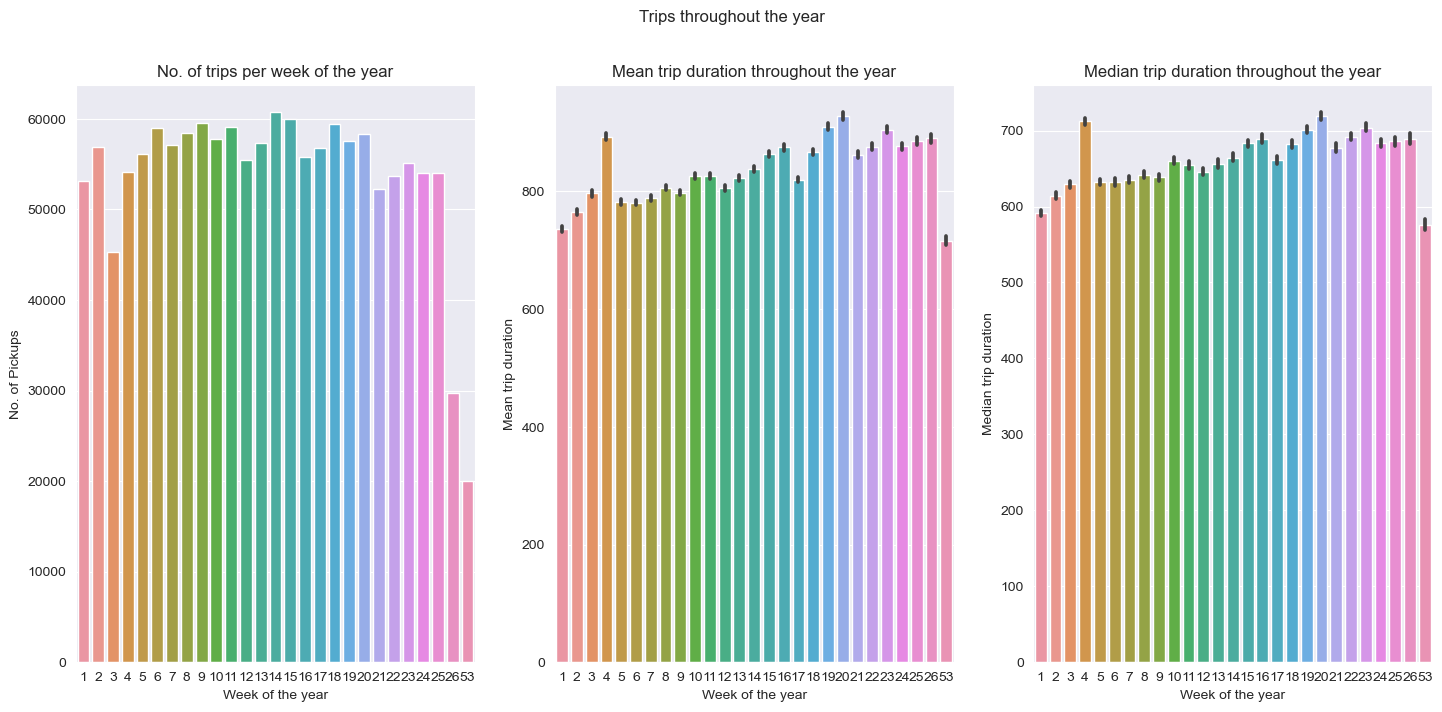

In [39]:
plt.figure(figsize=(17.5,7.5))
plt.suptitle('Trips throughout the year')
plt.subplot(1,3,1)
fig = sb.countplot(x=train_data["pickup_weekyear"])
fig.set(title = "No. of trips per week of the year",xlabel='Week of the year', ylabel='No. of Pickups')

plt.subplot(1,3,2)
fig = sb.barplot(x = train_data['pickup_weekyear'],y=train_data['trip_duration'],estimator='mean')
fig.set(title = "Mean trip duration throughout the year",xlabel='Week of the year', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = train_data['pickup_weekyear'],y=train_data['trip_duration'],estimator='median')
fig.set(title = "Median trip duration throughout the year",xlabel='Week of the year', ylabel='Median trip duration')
plt.show()

### Observation:

1) The number of trips is somewhat low during the 3rd week of the year and lowest during the 26th week.

2) 53rd week might be added because of the defects in the machine recording the trip details like date and time.

3) The mean and median trip durations are the highest during the 4th week of the year. 

In [32]:
train_data['pickup_weekyear'].describe()

count    1.456535e+06
mean     1.383924e+01
std      8.563962e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.300000e+01
75%      2.000000e+01
max      5.300000e+01
Name: pickup_weekyear, dtype: float64

## 2.2. Distance features

We added new distance features by calculating different distance between the pickup and dropoff locations.

1) Geodesic Distance
2) Great Circle Distance/Haversine Distance
3) Bearing Distance
4) Manhattan Distance
5) Euclidean Distance
6) Chebyshev Distance
7) Canberra DIstance
8) Squared Euclidean Distance
9) COsine Distacne
10) Braycurtis Distance

In [33]:
x1 = train_data['pickup_latitude'].values
y1 = train_data['pickup_longitude'].values
x2 = train_data['dropoff_latitude'].values
y2 = train_data['dropoff_longitude'].values

In [34]:
a1 = test_data['pickup_latitude'].values
b1 = test_data['pickup_longitude'].values
a2 = test_data['dropoff_latitude'].values
b2 = test_data['dropoff_longitude'].values

In [36]:
from geopy.distance import geodesic,great_circle
from scipy.spatial import distance
from tqdm import tqdm

In [37]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [38]:
train_geodesic_dist = []
train_euclidean_dist = []
train_manhattan_dist = [] #cityblock
train_chebyshev_dist = []
train_canberra_dist = []
train_sqeuclidean_dist = []
train_cosine_dist = []
train_braycurtis_dist = []
for i in tqdm(range(len(train_data))):
    train_geodesic_dist.append(geodesic((x1[i],y1[i]), (x2[i],y2[i])).km) #geodesic distance
    train_euclidean_dist.append(distance.euclidean([x1[i],y1[i]],[x2[i],y2[i]])) #euclidean distance
    train_manhattan_dist.append(distance.cityblock((x1[i],y1[i]), (x2[i],y2[i]))) #manhattan distance
    train_chebyshev_dist.append(distance.chebyshev([x1[i],y1[i]],[x2[i],y2[i]])) #chebyshev
    train_canberra_dist.append(distance.canberra([x1[i],y1[i]],[x2[i],y2[i]])) #canberra distance
    train_sqeuclidean_dist.append(distance.sqeuclidean([x1[i],y1[i]],[x2[i],y2[i]])) #sqeuclidean distance
    train_cosine_dist.append(distance.cosine([x1[i],y1[i]],[x2[i],y2[i]])) #cosine distance
    train_braycurtis_dist.append(distance.braycurtis([x1[i],y1[i]],[x2[i],y2[i]])) #braycurtis distance

100%|██████████████████████████████████████████████████████████████████████| 1456535/1456535 [10:45<00:00, 2255.82it/s]


In [39]:
test_geodesic_dist = []
test_euclidean_dist = []
test_manhattan_dist = [] 
test_chebyshev_dist = []
test_canberra_dist = []
test_sqeuclidean_dist = []
test_cosine_dist = []
test_braycurtis_dist = []
for i in tqdm(range(len(test_data))):
    test_geodesic_dist.append(geodesic((x1[i],y1[i]), (x2[i],y2[i])).km) #geodesic distance
    test_euclidean_dist.append(distance.euclidean([x1[i],y1[i]],[x2[i],y2[i]])) #euclidean distance
    test_manhattan_dist.append(distance.cityblock((x1[i],y1[i]), (x2[i],y2[i]))) #manhattan distance
    test_chebyshev_dist.append(distance.chebyshev([x1[i],y1[i]],[x2[i],y2[i]])) #chebyshev
    test_canberra_dist.append(distance.canberra([x1[i],y1[i]],[x2[i],y2[i]])) #canberra distance
    test_sqeuclidean_dist.append(distance.sqeuclidean([x1[i],y1[i]],[x2[i],y2[i]])) #sqeuclidean distance
    test_cosine_dist.append(distance.cosine([x1[i],y1[i]],[x2[i],y2[i]])) #cosine distance
    test_braycurtis_dist.append(distance.braycurtis([x1[i],y1[i]],[x2[i],y2[i]])) #braycurtis distance

100%|████████████████████████████████████████████████████████████████████████| 625115/625115 [05:00<00:00, 2079.55it/s]


In [40]:
train_data['haversine_dist'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

train_data['bearing_dist'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

In [42]:
train_data['geodesic_dist'] = train_geodesic_dist
train_data['euclidean_dist'] = train_euclidean_dist
train_data['manhattan_dist'] = train_manhattan_dist
train_data['chebyshev_dist'] = train_chebyshev_dist
train_data['canberra_dist'] = train_canberra_dist
train_data['sqeuclidean_dist'] = train_sqeuclidean_dist
train_data['cosine_dist'] = train_cosine_dist
train_data['braycurtis_dist'] = train_braycurtis_dist

In [43]:
test_data['haversine_dist'] = haversine_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

test_data['bearing_dist'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

In [44]:
test_data['geodesic_dist'] = test_geodesic_dist
test_data['euclidean_dist'] = test_euclidean_dist
test_data['manhattan_dist'] = test_manhattan_dist
test_data['chebyshev_dist'] = test_chebyshev_dist
test_data['canberra_dist'] = test_canberra_dist
test_data['sqeuclidean_dist'] = test_sqeuclidean_dist
test_data['cosine_dist'] = test_cosine_dist
test_data['braycurtis_dist'] = test_braycurtis_dist

In [45]:
train_data.head(5)

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  haversine_dist  bearing_dist  \
0         40.765602                  N  ...        1.498521     99.970196   
1         40.731152                  N  ...        1.805507   -117.153768   
2         40.710087                  N  ...        6.385098   -159.680165   
3         40.706718                  N  ...        1.485498   -172.737700   
4         40.782520                  N  ...        1.188588    179.473585   

   geodesic_dist  euclidean_dist  manhattan_dist  chebyshev_dist  \
0       1.502172        0.017680        0.019859        0.017525   
1       1.808660        0.020456        0.026478        0.019066   
2       6.379687        0.059934        0.080158        0.053852   
3       1.483632        0.013438        0.015480        0.013252   
4       1.187038        0.010690        0.010818        0.010689   

   canberra_dist  sqeuclidean_dist   cosine_dist  braycurtis_dist  
0       0.000147          0.000313  2.883154e-09         0.000087  
1       0.000220          0.000418  1.725008e-08         0.000115  
2       0.000839          0.003592  2.511432e-07         0.000349  
3       0.000178          0.000181  1.127590e-08         0.000067  
4       0.000132          0.000114  6.057234e-09         0.000047  

[5 rows x 26 columns]

In [46]:
test_data.head(5)

id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   
1  id3505355          1 2016-06-30 23:59:53                1   
2  id1217141          1 2016-06-30 23:59:47                1   
3  id2150126          2 2016-06-30 23:59:41                1   
4  id1598245          1 2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  pickup_hour  ...  haversine_dist  bearing_dist  \
0                  N           23  ...        2.746426     -3.595224   
1                  N           23  ...        2.759239    172.278835   
2                  N           23  ...        1.306155    133.326248   
3                  N           23  ...        5.269088   -150.956833   
4                  N           23  ...        0.960842    130.260381   

   geodesic_dist  euclidean_dist  manhattan_dist  chebyshev_dist  \
0       1.502172        0.017680        0.019859        0.017525   
1       1.808660        0.020456        0.026478        0.019066   
2       6.379687        0.059934        0.080158        0.053852   
3       1.483632        0.013438        0.015480        0.013252   
4       1.187038        0.010690        0.010818        0.010689   

   canberra_dist  sqeuclidean_dist   cosine_dist  braycurtis_dist  
0       0.000147          0.000313  2.883154e-09         0.000087  
1       0.000220          0.000418  1.725008e-08         0.000115  
2       0.000839          0.003592  2.511432e-07         0.000349  
3       0.000178          0.000181  1.127590e-08         0.000067  
4       0.000132          0.000114  6.057234e-09         0.000047  

[5 rows x 24 columns]

In [42]:
def dist_pdf_cdf_plots(data,variable,bins,plot_title,x_label,y_label='Probability'):
    counts, bins = np.histogram(train_data[variable],bins=bins,density=True)
    pdf = counts/sum(counts)
    cdf = np.cumsum(pdf)
    plt.title(plot_title)
    plt.plot(bins[1:],pdf[:],label='pdf')
    plt.xlabel(x_label)
    plt.plot(bins[1:],cdf[:],label='cdf')
    plt.ylabel(y_label)
    plt.legend(loc="upper left")

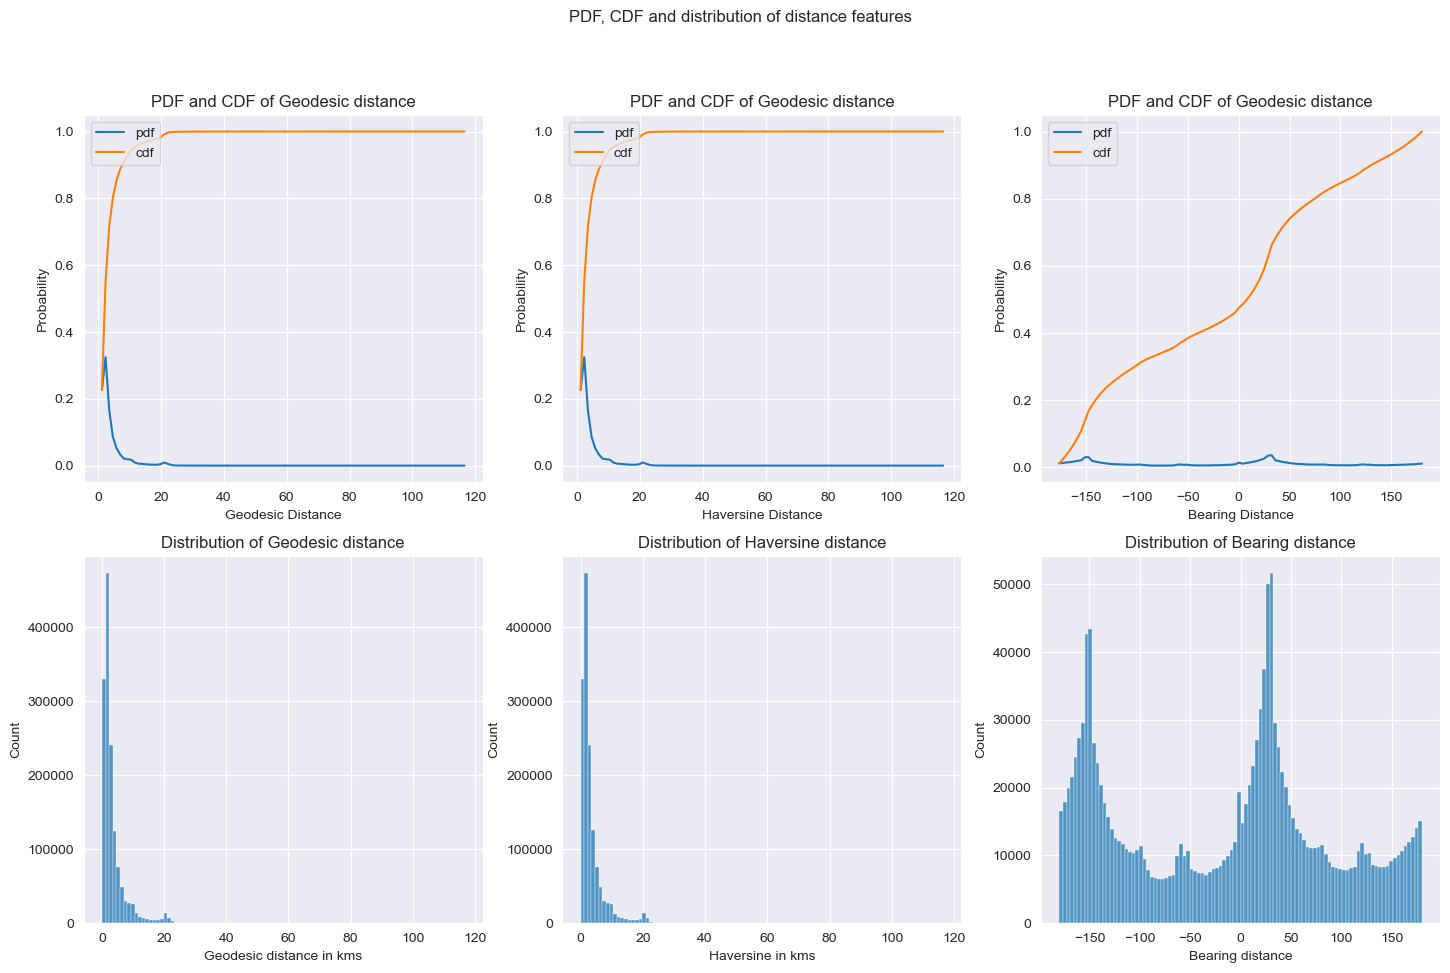

In [51]:
plt.figure(figsize=(17.5,10.5))
plt.suptitle('PDF, CDF and distribution of distance features')
plt.subplot(2,3,1)
dist_pdf_cdf_plots(data,'geodesic_dist',100,'PDF and CDF of Geodesic distance',"Geodesic Distance")

plt.subplot(2,3,2)
dist_pdf_cdf_plots(data,'haversine_dist',100,'PDF and CDF of Haversine distance',"Haversine Distance")

plt.subplot(2,3,3)
dist_pdf_cdf_plots(data,'bearing_dist',100,'PDF and CDF of Bearing distance',"Bearing Distance")

plt.subplot(2,3,4)
fig = sb.histplot(data['geodesic_dist'], bins=100)
fig.set(title = "Distribution of Geodesic distance",xlabel='Geodesic distance in kms', ylabel='Count')

plt.subplot(2,3,5)
fig = sb.histplot(data['haversine_dist'], bins=100)
fig.set(title = "Distribution of Haversine distance",xlabel='Haversine in kms')

plt.subplot(2,3,6)
fig = sb.histplot(data['bearing_dist'], bins=100)
fig.set(title = "Distribution of Bearing distance",xlabel='Bearing distance')

plt.show()

### Observation

1) Almost 99% of the Geodesic and Haversine distances are less than or equal to 20 kms

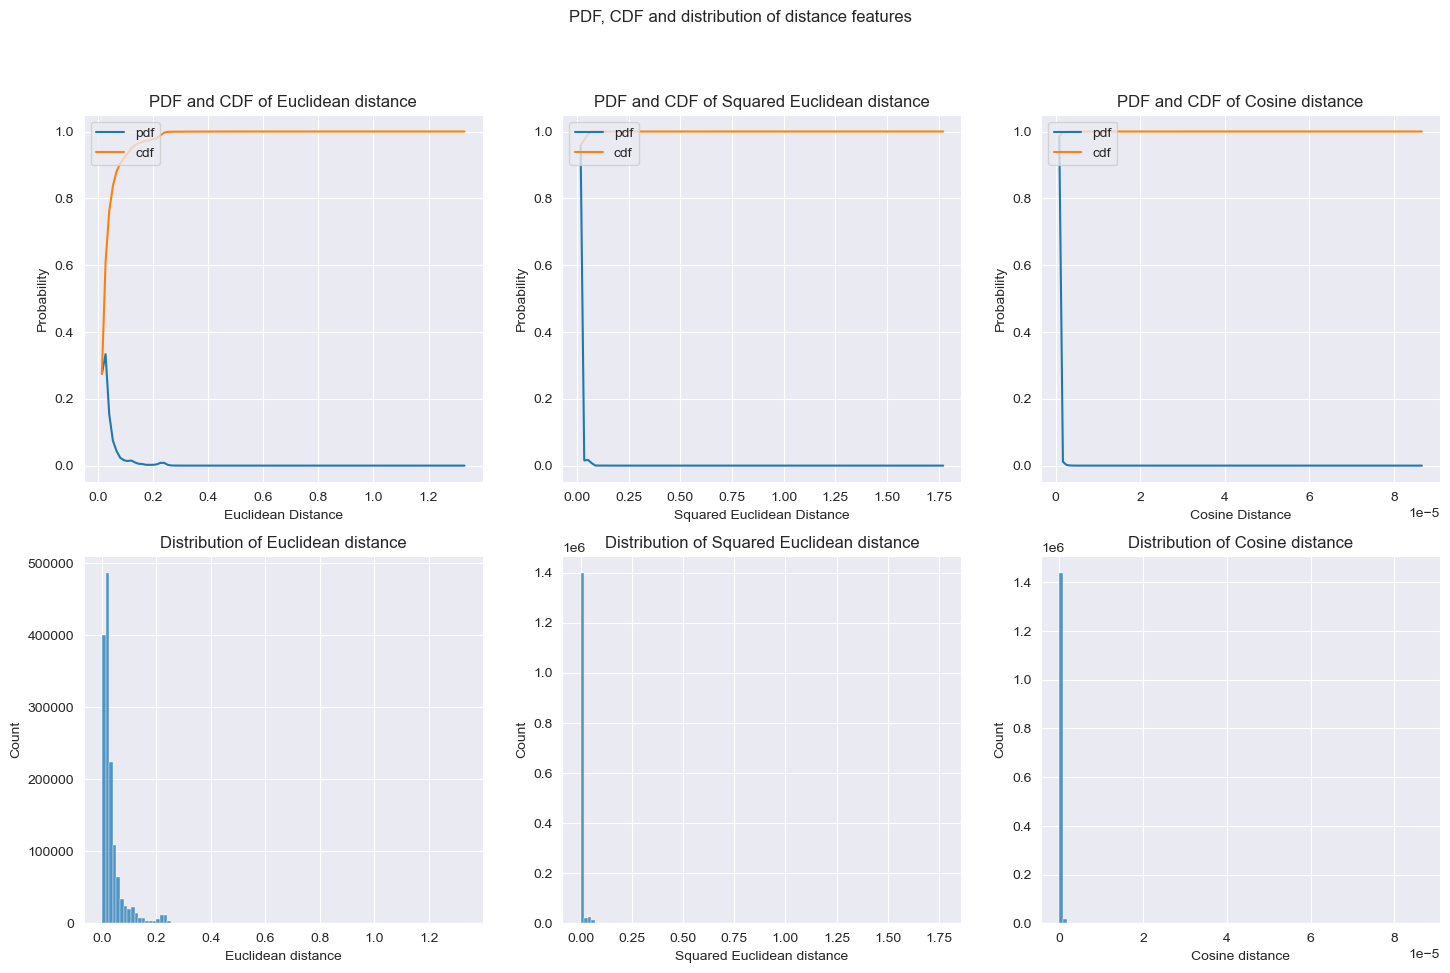

In [52]:
plt.figure(figsize=(17.5,10.5))
plt.suptitle('PDF, CDF and distribution of distance features')
plt.subplot(2,3,1)
dist_pdf_cdf_plots(train_data,'euclidean_dist',100,'PDF and CDF of Euclidean distance',"Euclidean Distance")

plt.subplot(2,3,2)
dist_pdf_cdf_plots(train_data,'sqeuclidean_dist',100,'PDF and CDF of Squared Euclidean distance',"Squared Euclidean Distance")

plt.subplot(2,3,3)
dist_pdf_cdf_plots(train_data,'cosine_dist',100,'PDF and CDF of Cosine distance',"Cosine Distance")

plt.subplot(2,3,4)
fig = sb.histplot(train_data['euclidean_dist'], bins=100)
fig.set(title = "Distribution of Euclidean distance",xlabel='Euclidean distance', ylabel='Count')

plt.subplot(2,3,5)
fig = sb.histplot(train_data['sqeuclidean_dist'], bins=100)
fig.set(title = "Distribution of Squared Euclidean distance",xlabel='Squared Euclidean distance')

plt.subplot(2,3,6)
fig = sb.histplot(train_data['cosine_dist'], bins=100)
fig.set(title = "Distribution of Cosine distance",xlabel='Cosine distance')

plt.show()

### Observation

1) Squared Euclidean distance and Cosine disatnce values are highly skewed.

2) Almost 99% of the euclidian distance values are less than or equal to 0.2.

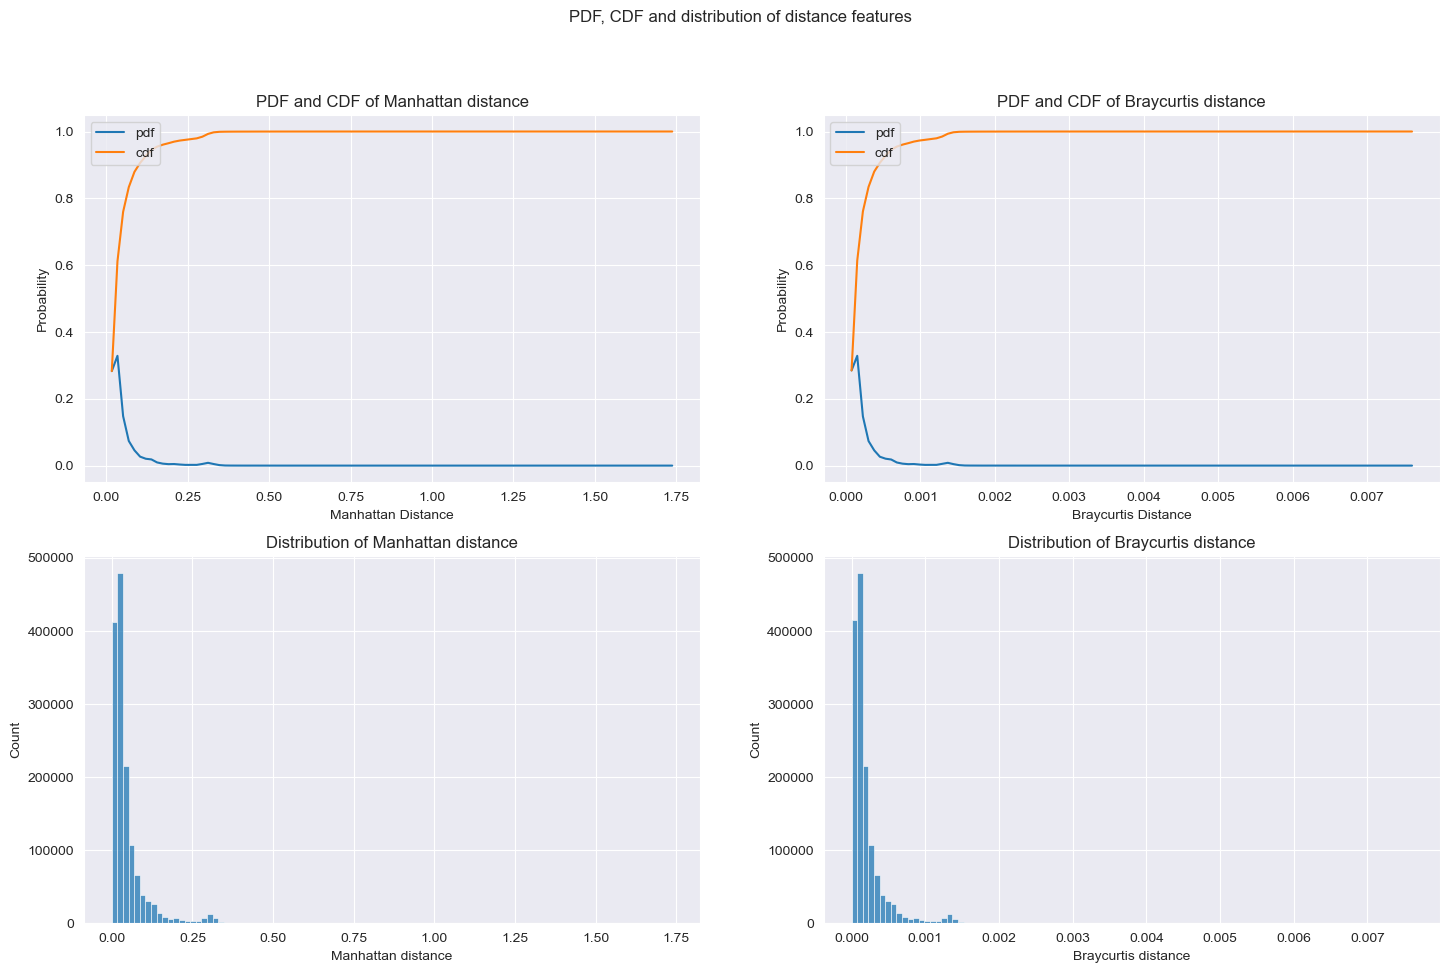

In [54]:
plt.figure(figsize=(17.5,10.5))
plt.suptitle('PDF, CDF and distribution of distance features')
plt.subplot(2,2,1)
dist_pdf_cdf_plots(train_data,'manhattan_dist',100,'PDF and CDF of Manhattan distance',"Manhattan Distance")

plt.subplot(2,2,2)
dist_pdf_cdf_plots(train_data,'braycurtis_dist',100,'PDF and CDF of Braycurtis distance',"Braycurtis Distance")

plt.subplot(2,2,3)
fig = sb.histplot(train_data['manhattan_dist'], bins=100)
fig.set(title = "Distribution of Manhattan distance",xlabel='Manhattan distance', ylabel='Count')

plt.subplot(2,2,4)
fig = sb.histplot(train_data['braycurtis_dist'], bins=100)
fig.set(title = "Distribution of Braycurtis distance",xlabel='Braycurtis distance', ylabel='Count')

plt.show()

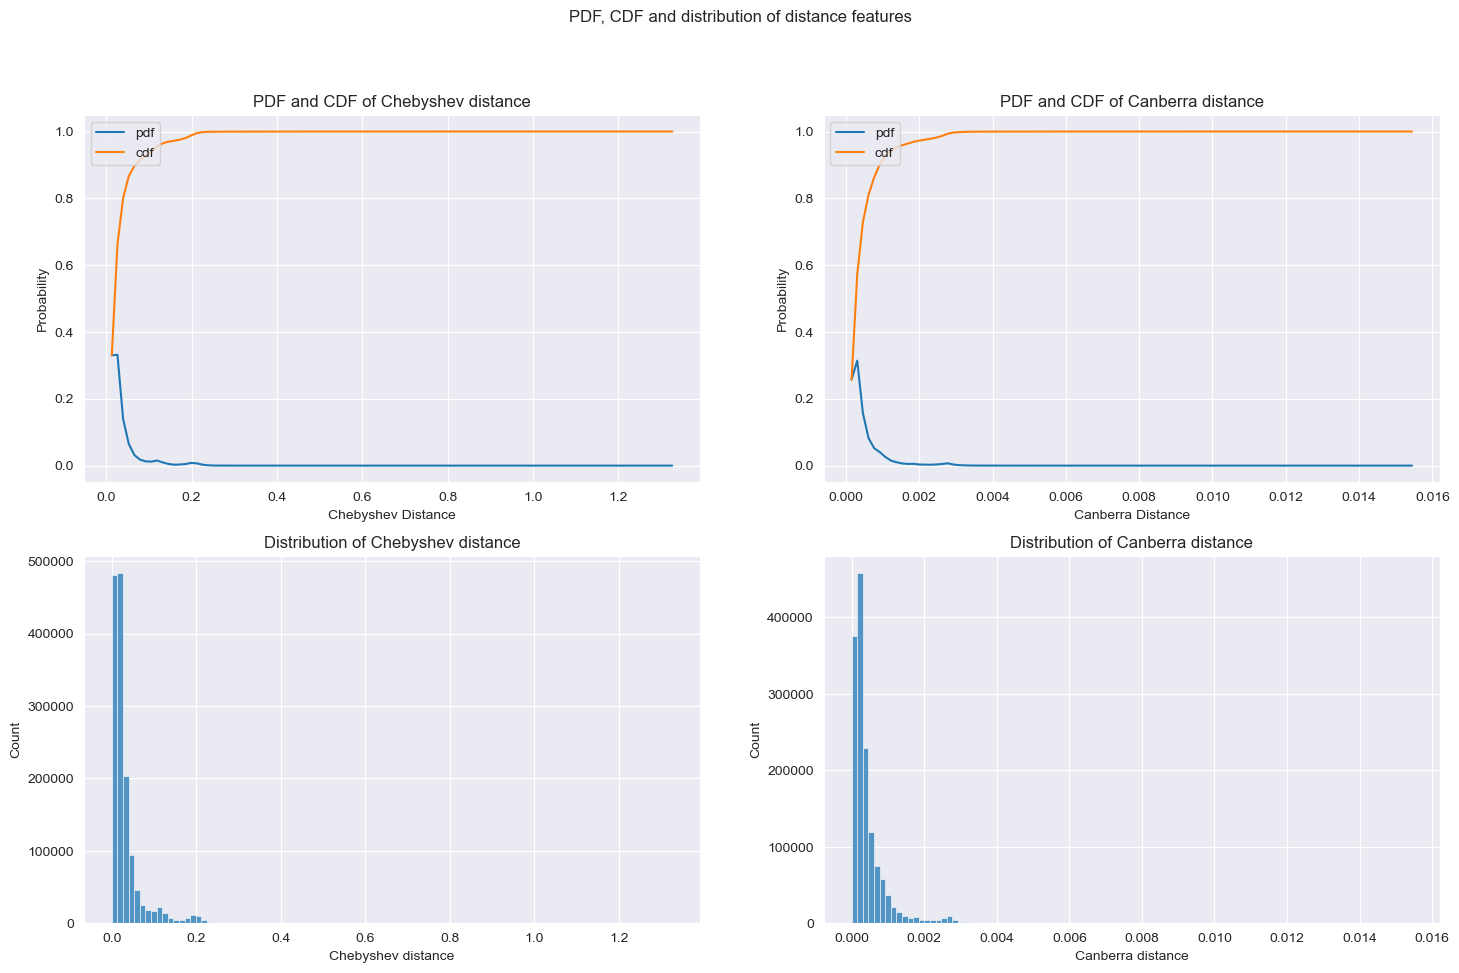

In [55]:
plt.figure(figsize=(17.5,10.5))
plt.suptitle('PDF, CDF and distribution of distance features')
plt.subplot(2,2,1)
dist_pdf_cdf_plots(train_data,'chebyshev_dist',100,'PDF and CDF of Chebyshev distance',"Chebyshev Distance")

plt.subplot(2,2,2)
dist_pdf_cdf_plots(train_data,'canberra_dist',100,'PDF and CDF of Canberra distance',"Canberra Distance")

plt.subplot(2,2,3)
fig = sb.histplot(train_data['chebyshev_dist'], bins=100)
fig.set(title = "Distribution of Chebyshev distance",xlabel='Chebyshev distance', ylabel='Count')

plt.subplot(2,2,4)
fig = sb.histplot(train_data['canberra_dist'], bins=100)
fig.set(title = "Distribution of Canberra distance",xlabel='Canberra distance', ylabel='Count')

plt.show()

### Observation

All the trip features are highly skewed. We need to transform them to normal distribution in order to use them for trip duration estimations.

In [48]:
train_data.columns[10:].tolist()

['trip_duration',
 'pickup_hour',
 'pickup_day',
 'pickup_day_of_week',
 'pickup_month',
 'pickup_weekyear',
 'haversine_dist',
 'bearing_dist',
 'geodesic_dist',
 'euclidean_dist',
 'manhattan_dist',
 'chebyshev_dist',
 'canberra_dist',
 'sqeuclidean_dist',
 'cosine_dist',
 'braycurtis_dist']

In [49]:
train_distances_data = train_data[train_data.columns[10:].tolist()]

In [50]:
train_distances_data.head(5)

trip_duration  pickup_hour  pickup_day  pickup_day_of_week  pickup_month  \
0            455           17          14                   0             3   
1            663            0          12                   6             6   
2           2124           11          19                   1             1   
3            429           19           6                   2             4   
4            435           13          26                   5             3   

   pickup_weekyear  haversine_dist  bearing_dist  geodesic_dist  \
0               11        1.498521     99.970196       1.502172   
1               23        1.805507   -117.153768       1.808660   
2                3        6.385098   -159.680165       6.379687   
3               14        1.485498   -172.737700       1.483632   
4               12        1.188588    179.473585       1.187038   

   euclidean_dist  manhattan_dist  chebyshev_dist  canberra_dist  \
0        0.017680        0.019859        0.017525       0.000147   
1        0.020456        0.026478        0.019066       0.000220   
2        0.059934        0.080158        0.053852       0.000839   
3        0.013438        0.015480        0.013252       0.000178   
4        0.010690        0.010818        0.010689       0.000132   

   sqeuclidean_dist   cosine_dist  braycurtis_dist  
0          0.000313  2.883154e-09         0.000087  
1          0.000418  1.725008e-08         0.000115  
2          0.003592  2.511432e-07         0.000349  
3          0.000181  1.127590e-08         0.000067  
4          0.000114  6.057234e-09         0.000047

<Figure size 1750x1250 with 0 Axes>

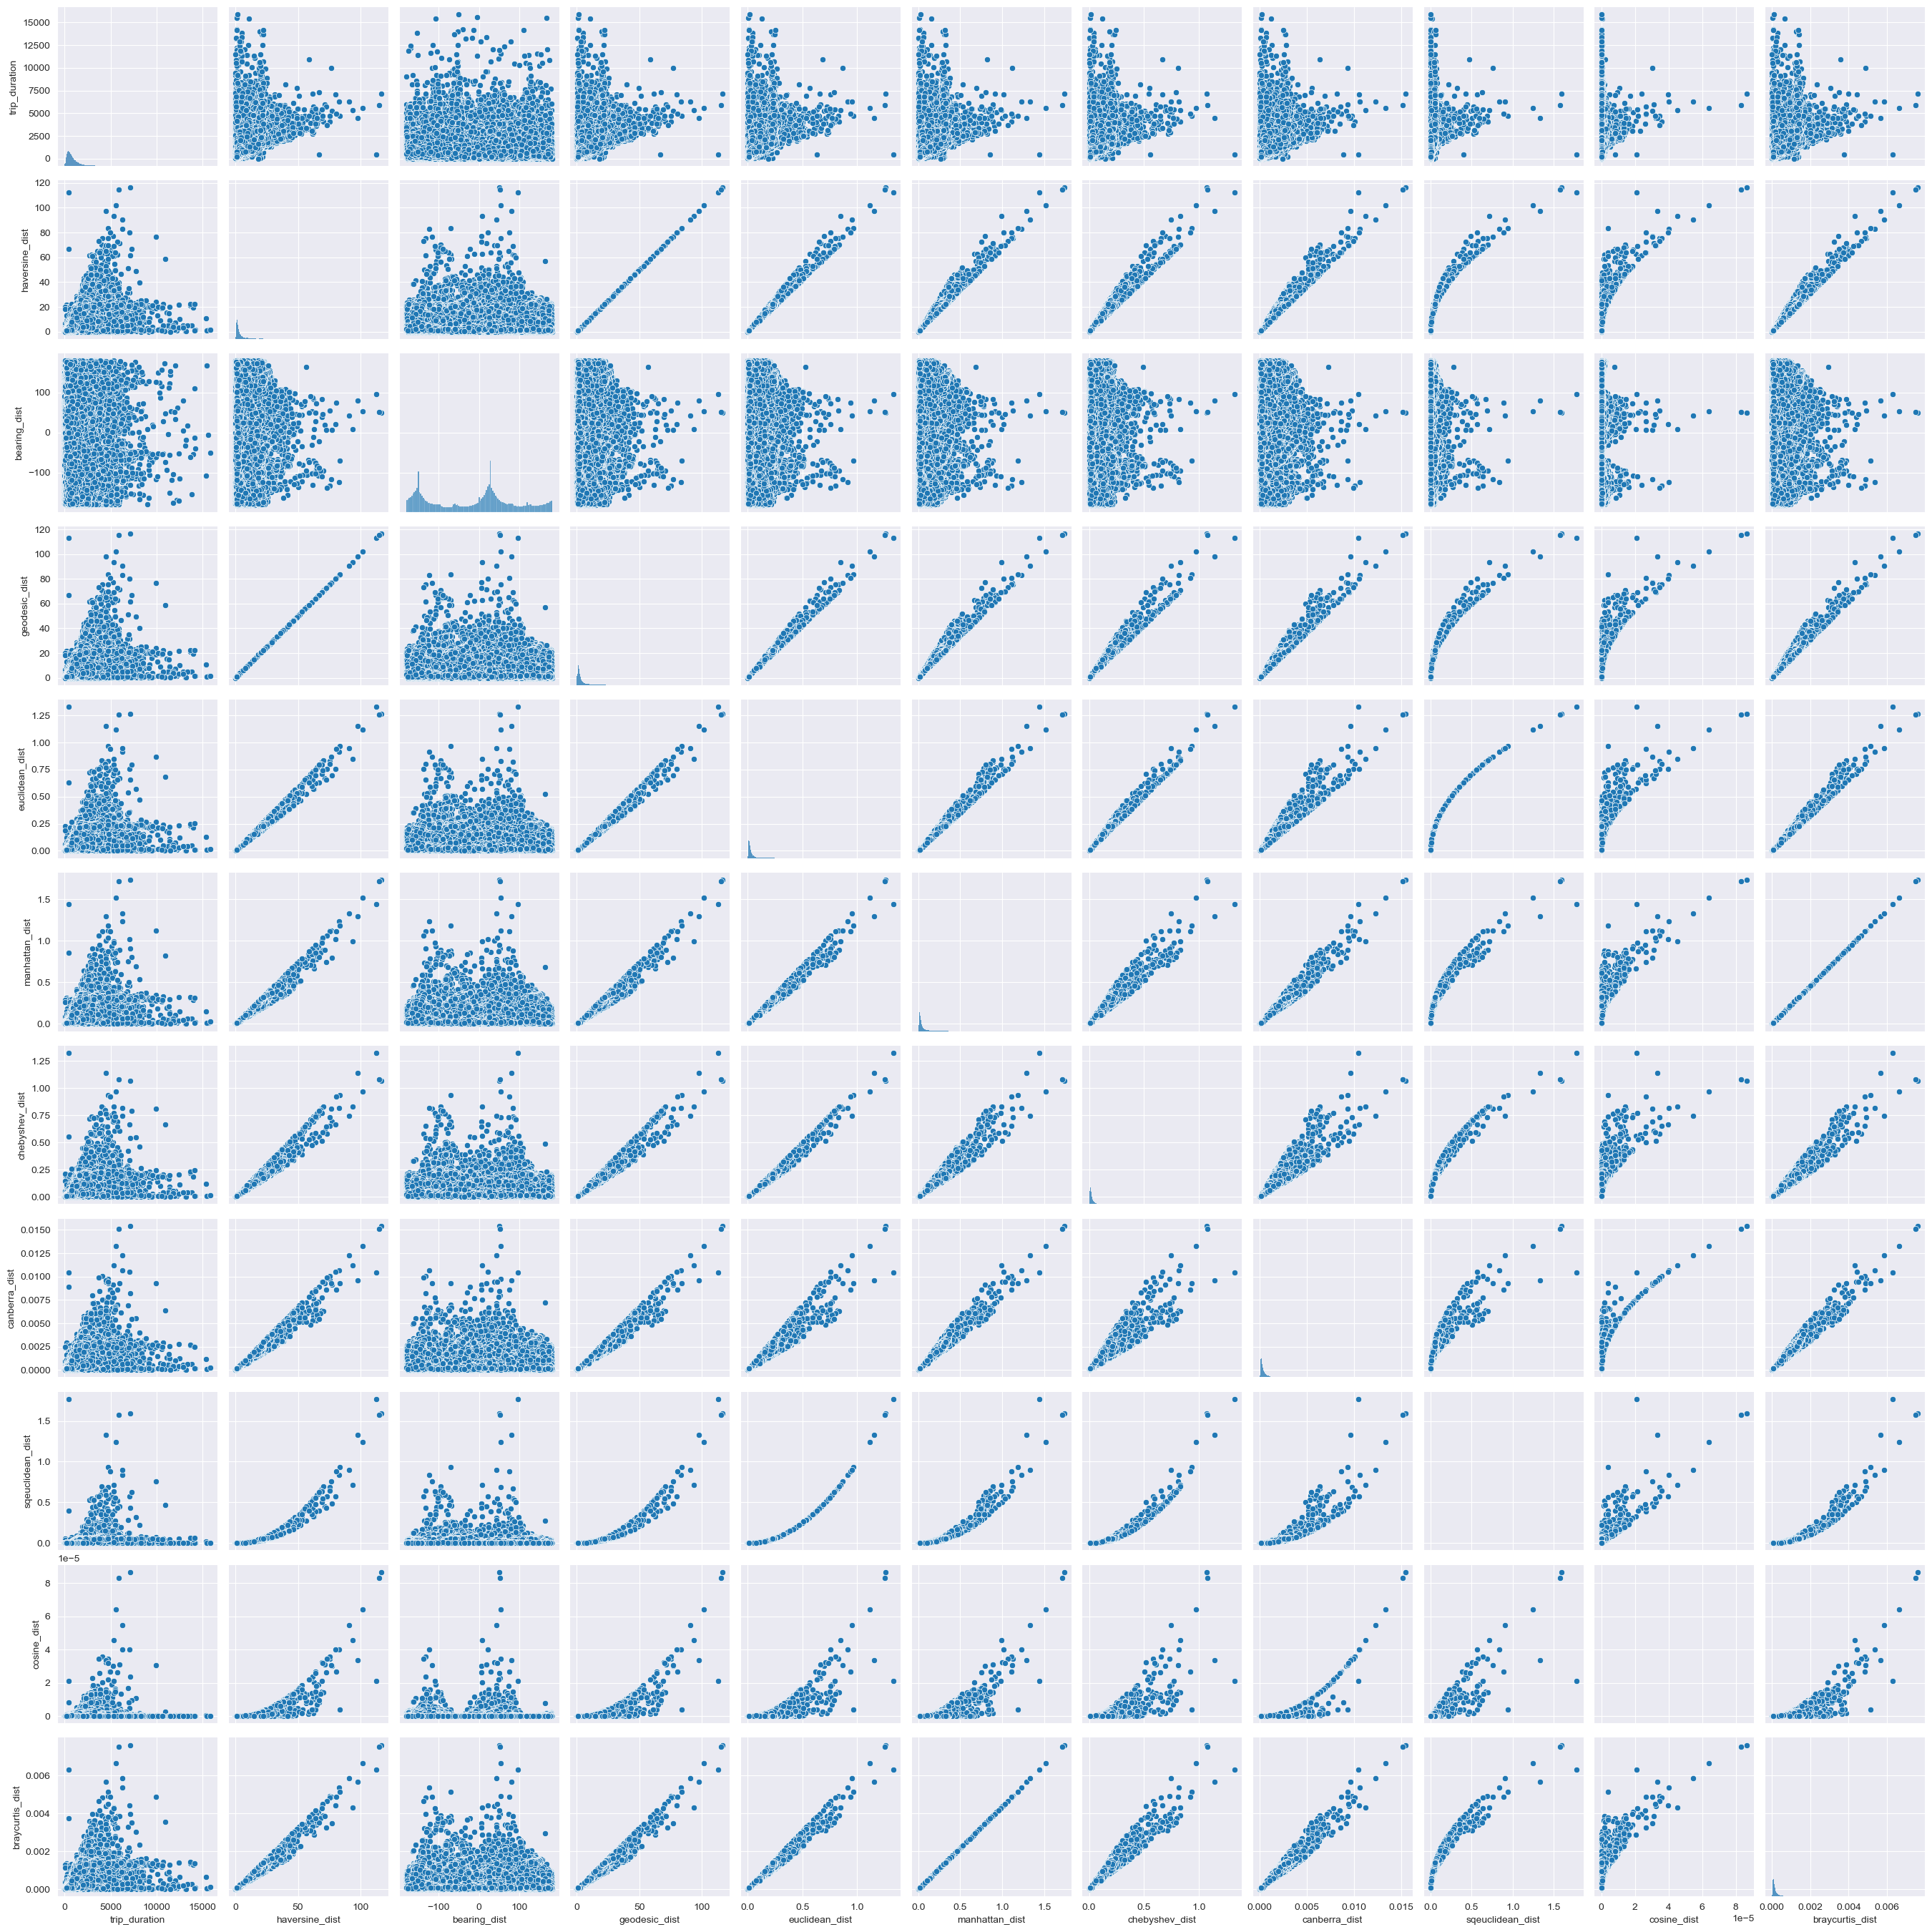

In [74]:
plt.figure(figsize=(17.5,12.5))
plt.suptitle('Comparison of distance variables with trip duration')
sb.pairplot(train_distances_data)
plt.show()

### Observation

1) Haversine distance wont have much impact when the distance betweeen the two locations is very small. In such cases, the earth's curvature is not taken into account.

2) Turns out, haversine distance and great circle distance are the same.

3) Almost all the distance features are having good correlation. This might result in feature collinearity issues 

## 2.3. Clustering-based features

3 different features were created by clustering the pickup locations, dropoff locations and combination of pickup and dropoff locations. A part of the training data is used for training and teh remaining is used for prediction. 

### Observation

Instead of using random clusters, we can use meaningful boundaries to create clusters which are more interpretable. So we are attempting to add external data like Neighborhood Tabulation Areas (NTA) to create 'meaningful' clusters instead of k-means based clusters. 

## 2.4. Adding New York City 2010 Neighborhood Tabulation Areas (NTA)

Instead of creating clusters from the pickup and dropoff locations, we can use external data to create the clusters which might be more meaningful. Different data like political boundaries, borough boundaries are available. We have used the Neighbourhood Tabulation Areas data. Along with NTA data, 2010 population data is also added.

Neighborhood Tabulation Areas (NTAs) are medium-sized statistical geographies for reporting Decennial Census and American Community Survey (ACS). NTAs were delineated with the need for both geographic specificity and statistical reliability in mind. Consequently, each NTA contains enough population to mitigate sampling error associated with the ACS yet offers a unit of analysis that is smaller than a Community District. Though NTA boundaries and their associated names roughly correspond with many neighborhoods commonly recognized by New Yorkers, NTAs are not intended to definitively represent neighborhoods, nor are they intended to be exhaustive of all possible names and understandings of neighborhoods throughout New York City. Additionally, non-residential areas including large parks, airports, cemeteries, and other special areas are represented separately within this dataset and are assigned codes according to their type.

Source: https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page?tab=2

## 2.4.1. Reading the NTA shapefile and changing the projection to match the train data

In [51]:
nta = gpd.read_file("C:/Users/ISR1/Documents/nyc/nynta2010_22c/nynta2010.shp")
nta.head(10)

BoroCode   BoroName CountyFIPS NTACode                NTAName  \
0         4     Queens        081    QN08             St. Albans   
1         2      Bronx        005    BX28  Van Cortlandt Village   
2         4     Queens        081    QN55       South Ozone Park   
3         3   Brooklyn        047    BK40        Windsor Terrace   
4         3   Brooklyn        047    BK50               Canarsie   
5         1  Manhattan        061    MN12        Upper West Side   
6         2      Bronx        005    BX41             Mount Hope   
7         4     Queens        081    QN26           North Corona   
8         3   Brooklyn        047    BK23          West Brighton   
9         4     Queens        081    QN56             Ozone Park   

     Shape_Leng    Shape_Area  \
0  45401.316921  7.741275e+07   
1  21945.719299  2.566612e+07   
2  36708.169488  8.246139e+07   
3  19033.671810  1.404167e+07   
4  43703.609550  8.208968e+07   
5  29160.206666  3.437994e+07   
6  18937.247498  1.471671e+07   
7  18429.539754  1.800389e+07   
8  14113.581549  8.738769e+06   
9  24730.068836  2.501677e+07   

                                            geometry  
0  POLYGON ((1052996.114 196307.361, 1053081.596 ...  
1  POLYGON ((1015481.863 261490.417, 1015482.771 ...  
2  POLYGON ((1038120.442 188146.832, 1038190.284 ...  
3  POLYGON ((989751.236 180153.483, 989741.619 18...  
4  MULTIPOLYGON (((1015236.113 174910.103, 101523...  
5  POLYGON ((995316.565 230026.304, 995180.306 22...  
6  POLYGON ((1013128.551 250637.755, 1012848.354 ...  
7  POLYGON ((1024560.201 215571.542, 1024640.130 ...  
8  POLYGON ((992892.358 148861.161, 992876.817 14...  
9  POLYGON ((1028591.796 187476.975, 1028761.196 ...

In [52]:
nta.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Observation:

NTA data has Borogh name, Borough Code, NTA name and NTA code information. The shape_area is reported in ft^2 and the CRS is EPSG:2263. We need to convert the CRS to EPSG:4326 so that NTA data overlays with our training data. The shape_area shouldalso be converted to km^2. It cn be done by multiplying with 0.00000009290304.

In [53]:
nta_reprojected = nta.to_crs(4326)
nta_reprojected.head(5)

BoroCode  BoroName CountyFIPS NTACode                NTAName    Shape_Leng  \
0         4    Queens        081    QN08             St. Albans  45401.316921   
1         2     Bronx        005    BX28  Van Cortlandt Village  21945.719299   
2         4    Queens        081    QN55       South Ozone Park  36708.169488   
3         3  Brooklyn        047    BK40        Windsor Terrace  19033.671810   
4         3  Brooklyn        047    BK50               Canarsie  43703.609550   

     Shape_Area                                           geometry  
0  7.741275e+07  POLYGON ((-73.75205 40.70523, -73.75174 40.704...  
1  2.566612e+07  POLYGON ((-73.88705 40.88435, -73.88705 40.884...  
2  8.246139e+07  POLYGON ((-73.80577 40.68293, -73.80552 40.682...  
3  1.404167e+07  POLYGON ((-73.98017 40.66115, -73.98021 40.661...  
4  8.208968e+07  MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...

### Observation:

After reprojecting, it can be noticed that the geometry of the new shape file has changed. NTA data will now overlay with the train data.

## 2.4.2. Reading NTA-wise population data

source: https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2/data

In [54]:
pop = pd.read_csv("C:/Users/ISR1/Documents/nyc/nynta2010_22c/Census_Demographics_at_the_Neighborhood_Tabulation_Area__NTA__level.csv")
pop.head(5)

Geographic Area - Borough  Geographic Area - 2010 Census FIPS County Code  \
0                     Bronx                                               5   
1                     Bronx                                               5   
2                     Bronx                                               5   
3                     Bronx                                               5   
4                     Bronx                                               5   

  Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               BX01           
1                                               BX03           
2                                               BX05           
3                                               BX06           
4                                               BX07           

  Geographic Area - Neighborhood Tabulation Area (NTA)* Name  \
0                                 Claremont-Bathgate           
1                    Eastchester-Edenwald-Baychester           
2                         Bedford Park-Fordham North           
3                                            Belmont           
4                                          Bronxdale           

   Total Population 2000 Number  Total Population 2010 Number  \
0                         28149                         31078   
1                         35422                         34517   
2                         55329                         54415   
3                         25967                         27378   
4                         34309                         35538   

   Total Population Change 2000-2010 Number  \
0                                      2929   
1                                      -905   
2                                      -914   
3                                      1411   
4                                      1229   

   Total Population Change 2000-2010 Percent  
0                                       10.4  
1                                       -2.6  
2                                       -1.7  
3                                        5.4  
4                                        3.6

In [55]:
len(pop['Geographic Area - Neighborhood Tabulation Area (NTA)* Name'].unique())

195

### Observation:

From the population data we will use only the 'Total Population 2010 Number' and 'Geographic Area - Neighborhood Tabulation Area (NTA)* Code' columns

In [56]:
new_pop = pop[['Geographic Area - Neighborhood Tabulation Area (NTA)* Code','Total Population 2010 Number']]

In [57]:
new_pop.head(5)

Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               BX01           
1                                               BX03           
2                                               BX05           
3                                               BX06           
4                                               BX07           

   Total Population 2010 Number  
0                         31078  
1                         34517  
2                         54415  
3                         27378  
4                         35538

## 2.4.3. Joining NTA shapefile data with NTA population data

In [58]:
new_nta = nta_reprojected.merge(new_pop, how='left', 
                                left_on='NTACode', 
                                right_on='Geographic Area - Neighborhood Tabulation Area (NTA)* Code')

In [59]:
new_nta.head(5)

BoroCode  BoroName CountyFIPS NTACode                NTAName    Shape_Leng  \
0         4    Queens        081    QN08             St. Albans  45401.316921   
1         2     Bronx        005    BX28  Van Cortlandt Village  21945.719299   
2         4    Queens        081    QN55       South Ozone Park  36708.169488   
3         3  Brooklyn        047    BK40        Windsor Terrace  19033.671810   
4         3  Brooklyn        047    BK50               Canarsie  43703.609550   

     Shape_Area                                           geometry  \
0  7.741275e+07  POLYGON ((-73.75205 40.70523, -73.75174 40.704...   
1  2.566612e+07  POLYGON ((-73.88705 40.88435, -73.88705 40.884...   
2  8.246139e+07  POLYGON ((-73.80577 40.68293, -73.80552 40.682...   
3  1.404167e+07  POLYGON ((-73.98017 40.66115, -73.98021 40.661...   
4  8.208968e+07  MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...   

  Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               QN08           
1                                               BX28           
2                                               QN55           
3                                               BK40           
4                                               BK50           

   Total Population 2010 Number  
0                         48593  
1                         50100  
2                         75878  
3                         20988  
4                         83693

In [60]:
new_nta['area_km2'] = new_nta['Shape_Area'].values * 0.00000009290304

In [62]:
new_nta['area_km2'].describe()

count    195.000000
mean       4.012922
std        4.132889
min        0.517987
25%        1.800639
50%        3.031407
75%        4.662350
max       30.397362
Name: area_km2, dtype: float64

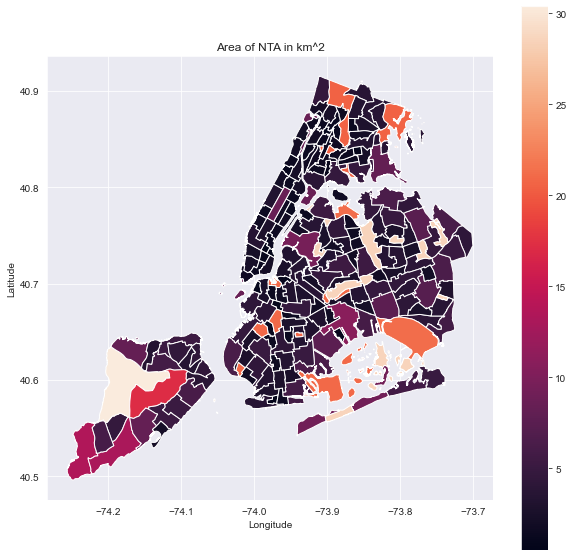

In [63]:
new_nta.plot(column='area_km2',figsize=(10,10),legend=True)
plt.title('Area of NTA in km^2')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

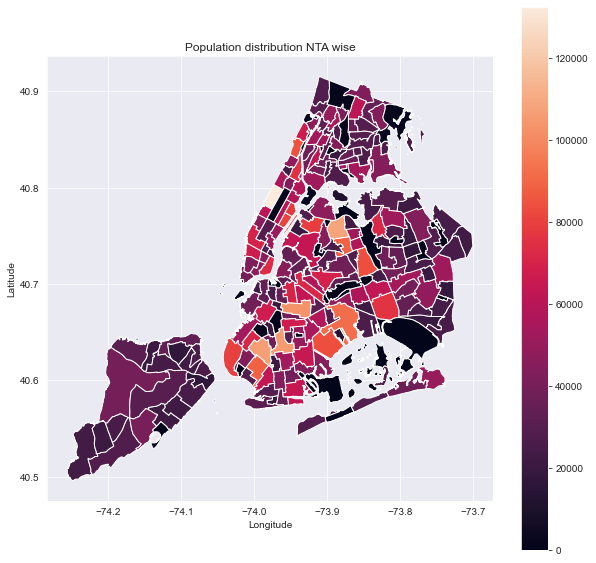

In [64]:
new_nta.plot(column='Total Population 2010 Number',figsize=(10,10),legend=True)
plt.title('Population distribution NTA wise')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

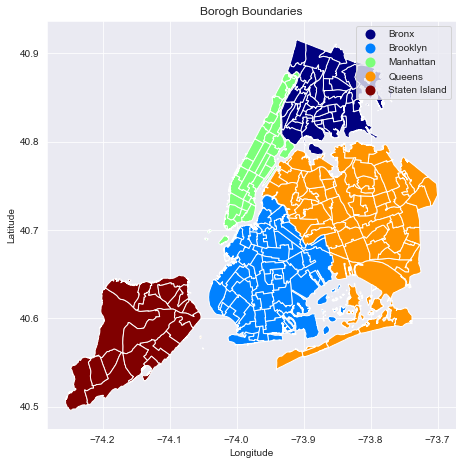

In [65]:
new_nta.plot(column='BoroName',figsize=(7.5,7.5),legend=True,cmap='jet')
plt.title('Borogh Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

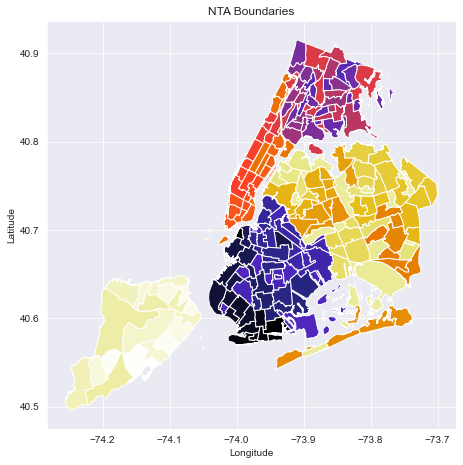

In [66]:
new_nta.plot(column='NTACode',figsize=(7.5,7.5),legend=False,cmap='CMRmap')
plt.title('NTA Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 2.4.4. Converting training data into two different files based on pickup and dropoff locations

Two shapefiles are created usng the pickup and dropoff locations. We can perform spatial joins on these shapefiles with the train data, so that the pickup and dropoff, NTA, Borough and population information can be added.  

In [67]:
train_pickups = gpd.GeoDataFrame(train_data, geometry = gpd.points_from_xy(train_data['pickup_longitude'], train_data['pickup_latitude']), crs = 'EPSG:4326')
train_drops = gpd.GeoDataFrame(train_data, geometry = gpd.points_from_xy(train_data['dropoff_longitude'], train_data['dropoff_latitude']), crs = 'EPSG:4326')

D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [68]:
test_pickups = gpd.GeoDataFrame(test_data, geometry = gpd.points_from_xy(test_data['pickup_longitude'], test_data['pickup_latitude']), crs = 'EPSG:4326')
test_drops = gpd.GeoDataFrame(test_data, geometry = gpd.points_from_xy(test_data['dropoff_longitude'], test_data['dropoff_latitude']), crs = 'EPSG:4326')

D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


## 2.4.5. Spatial Join NTA data with pickup locations

In [69]:
train_x = sjoin(train_pickups, new_nta, how="left",op="within")
test_x = sjoin(test_pickups, new_nta, how="left",op="within")

In [71]:
train_x.head(5)

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  BoroCode   BoroName  CountyFIPS  \
0         40.765602                  N  ...       1.0  Manhattan         061   
1         40.731152                  N  ...       1.0  Manhattan         061   
2         40.710087                  N  ...       1.0  Manhattan         061   
3         40.706718                  N  ...       1.0  Manhattan         061   
4         40.782520                  N  ...       1.0  Manhattan         061   

   NTACode                                 NTAName    Shape_Leng  \
0     MN14                          Lincoln Square  19871.831349   
1     MN20                    Murray Hill-Kips Bay  24230.207611   
2     MN17                   Midtown-Midtown South  27032.730332   
3     MN24  SoHo-TriBeCa-Civic Center-Little Italy  26855.031627   
4     MN12                         Upper West Side  29160.206666   

     Shape_Area  Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0  1.580591e+07                                               MN14            
1  1.445939e+07                                               MN20            
2  3.019128e+07                                               MN17            
3  2.503268e+07                                               MN24            
4  3.437994e+07                                               MN12            

   Total Population 2010 Number  area_km2  
0                       61489.0  1.468418  
1                       50742.0  1.343321  
2                       28630.0  2.804861  
3                       42742.0  2.325612  
4                      132378.0  3.194001  

[5 rows x 38 columns]

In [72]:
test_x.head(5)

id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   
1  id3505355          1 2016-06-30 23:59:53                1   
2  id1217141          1 2016-06-30 23:59:47                1   
3  id2150126          2 2016-06-30 23:59:41                1   
4  id1598245          1 2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  pickup_hour  ...  BoroCode   BoroName  CountyFIPS  \
0                  N           23  ...       1.0  Manhattan         061   
1                  N           23  ...       3.0   Brooklyn         047   
2                  N           23  ...       1.0  Manhattan         061   
3                  N           23  ...       1.0  Manhattan         061   
4                  N           23  ...       1.0  Manhattan         061   

   NTACode                      NTAName    Shape_Leng    Shape_Area  \
0     MN22                 East Village  13555.231504  1.089424e+07   
1     BK64             Prospect Heights  15094.537109  1.023348e+07   
2     MN23                 West Village  27119.922474  2.488638e+07   
3     MN31  Lenox Hill-Roosevelt Island  38404.485333  2.150862e+07   
4     MN19      Turtle Bay-East Midtown  21251.841741  1.739017e+07   

   Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               MN22            
1                                               BK64            
2                                               MN23            
3                                               MN31            
4                                               MN19            

   Total Population 2010 Number  area_km2  
0                       44136.0  1.012108  
1                       19849.0  0.950722  
2                       66880.0  2.312020  
3                       80771.0  1.998216  
4                       51231.0  1.615600  

[5 rows x 36 columns]

In [75]:
print(train_x.BoroName.isna().sum())
print(test_x.BoroName.isna().sum())

1191
512


In [76]:
train_x.BoroName = train_x.BoroName.fillna('Others')
test_x.BoroName = test_x.BoroName.fillna('Others')

In [77]:
print(train_x.BoroName.isna().sum())
print(test_x.BoroName.isna().sum())

0
0


In [78]:
print(train_x.NTACode.isna().sum())
print(test_x.NTACode.isna().sum())

1191
512


In [79]:
train_x.NTACode = train_x.NTACode.fillna('Others')
test_x.NTACode = test_x.NTACode.fillna('Others')

In [80]:
print(train_x.NTACode.isna().sum())
print(test_x.NTACode.isna().sum())

0
0


In [85]:
print(train_x.NTACode.unique())
print(test_x.NTACode.unique())

['MN14' 'MN20' 'MN17' 'MN24' 'MN12' 'MN21' 'MN19' 'MN23' 'MN31' 'MN15'
 'MN13' 'MN27' 'MN40' 'BK73' 'MN25' 'MN22' 'MN99' 'MN34' 'QN98' 'BK90'
 'MN32' 'MN09' 'MN33' 'MN28' 'QN31' 'BK33' 'QN29' 'BK38' 'MN11' 'BK78'
 'QN70' 'BK77' 'MN03' 'QN55' 'BK64' 'BK68' 'QN50' 'MN04' 'MN35' 'MN06'
 'BK37' 'BK76' 'BK09' 'QN27' 'QN99' 'MN50' 'QN71' 'BK50' 'BK63' 'BK69'
 'BK29' 'Others' 'BK75' 'MN36' 'QN72' 'BK99' 'QN26' 'QN63' 'QN68' 'BK85'
 'BK35' 'QN18' 'QN61' 'BK72' 'QN22' 'BK32' 'MN01' 'BX63' 'BK60' 'QN17'
 'BK61' 'BK95' 'BX39' 'BK40' 'QN01' 'QN07' 'QN54' 'BK41' 'QN28' 'BX34'
 'QN76' 'BK96' 'QN03' 'BK42' 'QN30' 'QN21' 'BX99' 'BK79' 'QN62' 'BK28'
 'QN52' 'QN56' 'QN53' 'BX30' 'BX36' 'SI37' 'BX08' 'QN35' 'BK34' 'BX03'
 'QN60' 'BK88' 'BK58' 'BK25' 'BX31' 'QN20' 'BX37' 'BX26' 'SI14' 'BK43'
 'BK17' 'BX01' 'BX06' 'QN38' 'QN49' 'QN19' 'BX46' 'BX52' 'BX59' 'BK31'
 'QN25' 'BX33' 'QN37' 'QN06' 'BX29' 'BX40' 'QN05' 'BK21' 'SI22' 'BX27'
 'BX41' 'BK83' 'BK27' 'BX17' 'BK91' 'BX14' 'BX35' 'BK81' 'BX28' 'BK19'
 'BX

In [84]:
print(train_x.BoroName.unique())
print(test_x.BoroName.unique())

['Manhattan' 'Brooklyn' 'Queens' 'Others' 'Bronx' 'Staten Island']
['Manhattan' 'Brooklyn' 'Queens' 'Others' 'Bronx' 'Staten Island']


### Observation:

1191 pickup points are outlide the city limits. Thats why, after the spatial table join, 1191 values are left with null values. Now we need to replace these values with 'others' class.


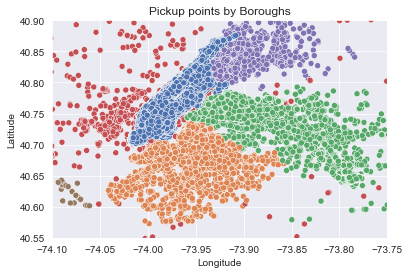

In [49]:
city_long_border = (-74.10, -73.75)
city_lat_border = (40.55, 40.90)
fig = sb.scatterplot(data = train_x,x='pickup_longitude',y='pickup_latitude',hue='BoroName',palette="deep",legend=False)
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Pickup points by Boroughs",xlabel="Longitude",ylabel="Latitude")
plt.show()

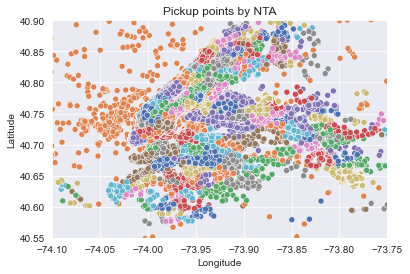

In [53]:
fig = sb.scatterplot(data =train_x,x='pickup_longitude',y='pickup_latitude',hue='NTACode',palette="deep",legend=False)
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Pickup points by NTA",xlabel="Longitude",ylabel="Latitude")
plt.show()

## 2.4.6. Spatial Join NTA data with dropoff locations

In [86]:
train_y = sjoin(train_drops, new_nta, how="left",op="within") #new_nta_reprojected
test_y = sjoin(test_drops, new_nta, how="left",op="within") #new_nta_reprojected

In [87]:
train_y.head(3)

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude store_and_fwd_flag  ...  BoroCode   BoroName  CountyFIPS  \
0         40.765602                  N  ...       1.0  Manhattan         061   
1         40.731152                  N  ...       1.0  Manhattan         061   
2         40.710087                  N  ...       1.0  Manhattan         061   

   NTACode                            NTAName    Shape_Leng    Shape_Area  \
0     MN40      Upper East Side-Carnegie Hill  23778.410499  2.006536e+07   
1     MN23                       West Village  27119.922474  2.488638e+07   
2     MN25  Battery Park City-Lower Manhattan  43727.725101  1.901167e+07   

   Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               MN40            
1                                               MN23            
2                                               MN25            

   Total Population 2010 Number  area_km2  
0                       61207.0  1.864133  
1                       66880.0  2.312020  
2                       39699.0  1.766242  

[3 rows x 38 columns]

In [88]:
test_y.head(3)

id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   
1  id3505355          1 2016-06-30 23:59:53                1   
2  id1217141          1 2016-06-30 23:59:47                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   

  store_and_fwd_flag  pickup_hour  ...  BoroCode   BoroName  CountyFIPS  \
0                  N           23  ...       1.0  Manhattan         061   
1                  N           23  ...       3.0   Brooklyn         047   
2                  N           23  ...       1.0  Manhattan         061   

   NTACode                            NTAName    Shape_Leng    Shape_Area  \
0     MN17              Midtown-Midtown South  27032.730332  3.019128e+07   
1     BK60  Prospect Lefferts Gardens-Wingate  29563.271246  3.163918e+07   
2     MN22                       East Village  13555.231504  1.089424e+07   

   Geographic Area - Neighborhood Tabulation Area (NTA)* Code  \
0                                               MN17            
1                                               BK60            
2                                               MN22            

   Total Population 2010 Number  area_km2  
0                       28630.0  2.804861  
1                       67459.0  2.939376  
2                       44136.0  1.012108  

[3 rows x 36 columns]

In [89]:
print(train_y.BoroName.isna().sum())
print(test_y.BoroName.isna().sum())

6285
2621


In [90]:
train_y.BoroName = train_y.BoroName.fillna('Others')
test_y.BoroName = test_y.BoroName.fillna('Others')

In [91]:
print(train_y.BoroName.isna().sum())
print(test_y.BoroName.isna().sum())

0
0


In [92]:
print(train_y.NTACode.isna().sum())
print(test_y.NTACode.isna().sum())

6285
2621


In [93]:
train_y.NTACode = train_y.NTACode.fillna('Others')
test_y.NTACode = test_y.NTACode.fillna('Others')

In [94]:
print(train_y.NTACode.isna().sum())
print(test_y.NTACode.isna().sum())

0
0


In [95]:
print(train_y.NTACode.unique())
print(test_y.NTACode.unique())

['MN40' 'MN23' 'MN25' 'MN12' 'MN17' 'MN31' 'QN70' 'MN21' 'MN32' 'MN24'
 'MN20' 'MN22' 'MN13' 'QN98' 'MN50' 'MN11' 'BK61' 'BK38' 'BK33' 'MN28'
 'MN14' 'MN27' 'BX52' 'QN01' 'BK69' 'MN19' 'MN01' 'QN17' 'MN15' 'BK68'
 'MN99' 'Others' 'QN27' 'BK42' 'MN35' 'QN20' 'MN03' 'QN38' 'MN33' 'BK78'
 'BK73' 'QN21' 'MN09' 'BK90' 'BK77' 'BK79' 'QN63' 'BK35' 'BK32' 'BX55'
 'QN72' 'QN55' 'QN31' 'QN06' 'MN34' 'MN06' 'QN54' 'BK75' 'BK43' 'QN29'
 'QN60' 'BX63' 'BK21' 'BK76' 'QN25' 'BX36' 'BK09' 'MN36' 'BK37' 'BX27'
 'BK40' 'BX34' 'MN04' 'BK99' 'BX29' 'BX22' 'QN71' 'BX07' 'QN35' 'BK19'
 'BK63' 'QN30' 'BK50' 'QN26' 'BK28' 'BK83' 'BX14' 'BK45' 'QN68' 'BK91'
 'QN34' 'BK81' 'BK60' 'BK64' 'BK31' 'QN23' 'BX39' 'QN22' 'BK82' 'QN51'
 'QN62' 'BX41' 'BX28' 'QN45' 'QN28' 'QN49' 'BK72' 'BX33' 'BX26' 'BK29'
 'BK85' 'BK88' 'QN99' 'QN19' 'BK96' 'BX06' 'BK95' 'QN18' 'QN42' 'QN07'
 'SI22' 'QN56' 'BX01' 'BK25' 'BK93' 'QN76' 'BX03' 'QN61' 'BX62' 'QN46'
 'BX37' 'BX05' 'BX30' 'BK34' 'BX08' 'QN02' 'BX49' 'BK17' 'QN53' 'BX43'
 'QN

In [96]:
print(train_y.BoroName.unique())
print(test_y.BoroName.unique())

['Manhattan' 'Queens' 'Brooklyn' 'Bronx' 'Others' 'Staten Island']
['Manhattan' 'Brooklyn' 'Bronx' 'Queens' 'Others' 'Staten Island']


### Observation:

6285 trips are missing NTACode and Borough Name information i.e. they are outside the NYC boundaries.

## 2.4.7. Transferring the pickup, dropoff NTA and Borough information to train data

In [97]:
train_data['pickup_boro'] = train_x.BoroName.values
train_data['pickup_nta'] = train_x.NTACode.values
train_data['dropoff_boro'] = train_y.BoroName.values
train_data['dropoff_nta'] = train_y.NTACode.values
train_data['pickup_pop'] = train_x['Total Population 2010 Number'].values
train_data['pickup_area'] = train_x['area_km2'].values
train_data['dropoff_pop'] = train_y['Total Population 2010 Number'].values
train_data['dropoff_area'] = train_y['area_km2'].values

In [99]:
test_data['pickup_boro'] = test_x.BoroName.values
test_data['pickup_nta'] = test_x.NTACode.values
test_data['dropoff_boro'] = test_y.BoroName.values
test_data['dropoff_nta'] = test_y.NTACode.values
test_data['pickup_pop'] = test_x['Total Population 2010 Number'].values
test_data['pickup_area'] = test_x['area_km2'].values
test_data['dropoff_pop'] = test_y['Total Population 2010 Number'].values
test_data['dropoff_area'] = test_y['area_km2'].values

In [98]:
train_data.head(3)

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude store_and_fwd_flag  ...  braycurtis_dist  \
0         40.765602                  N  ...         0.000087   
1         40.731152                  N  ...         0.000115   
2         40.710087                  N  ...         0.000349   

                     geometry  pickup_boro  pickup_nta  dropoff_boro  \
0  POINT (-73.96463 40.76560)    Manhattan        MN14     Manhattan   
1  POINT (-73.99948 40.73115)    Manhattan        MN20     Manhattan   
2  POINT (-74.00533 40.71009)    Manhattan        MN17     Manhattan   

   dropoff_nta  pickup_pop  pickup_area  dropoff_pop  dropoff_area  
0         MN40     61489.0     1.468418      61207.0      1.864133  
1         MN23     50742.0     1.343321      66880.0      2.312020  
2         MN25     28630.0     2.804861      39699.0      1.766242  

[3 rows x 35 columns]

In [100]:
test_data.head(3)

id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   
1  id3505355          1 2016-06-30 23:59:53                1   
2  id1217141          1 2016-06-30 23:59:47                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   

  store_and_fwd_flag  pickup_hour  ...  braycurtis_dist  \
0                  N           23  ...         0.000087   
1                  N           23  ...         0.000115   
2                  N           23  ...         0.000349   

                     geometry  pickup_boro  pickup_nta  dropoff_boro  \
0  POINT (-73.99017 40.75668)    Manhattan        MN22     Manhattan   
1  POINT (-73.95981 40.65540)     Brooklyn        BK64      Brooklyn   
2  POINT (-73.98616 40.72952)    Manhattan        MN23     Manhattan   

   dropoff_nta  pickup_pop  pickup_area  dropoff_pop  dropoff_area  
0         MN17     44136.0     1.012108      28630.0      2.804861  
1         BK60     19849.0     0.950722      67459.0      2.939376  
2         MN22     66880.0     2.312020      44136.0      1.012108  

[3 rows x 33 columns]

In [101]:
train_data = train_data.drop(['id','pickup_datetime','dropoff_datetime','geometry'],axis=1)

In [102]:
train_data.head(3)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                  N            455   
1         -73.999481         40.731152                  N            663   
2         -74.005333         40.710087                  N           2124   

   pickup_hour  pickup_day  ...   cosine_dist  braycurtis_dist  pickup_boro  \
0           17          14  ...  2.883154e-09         0.000087    Manhattan   
1            0          12  ...  1.725008e-08         0.000115    Manhattan   
2           11          19  ...  2.511432e-07         0.000349    Manhattan   

   pickup_nta  dropoff_boro  dropoff_nta  pickup_pop  pickup_area  \
0        MN14     Manhattan         MN40     61489.0     1.468418   
1        MN20     Manhattan         MN23     50742.0     1.343321   
2        MN17     Manhattan         MN25     28630.0     2.804861   

   dropoff_pop  dropoff_area  
0      61207.0      1.864133  
1      66880.0      2.312020  
2      39699.0      1.766242  

[3 rows x 31 columns]

In [103]:
test_data = test_data.drop(['id','pickup_datetime','geometry'],axis=1)
test_data.head(3)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  pickup_hour  \
0         -73.990173         40.756680                  N           23   
1         -73.959808         40.655403                  N           23   
2         -73.986160         40.729523                  N           23   

   pickup_day  pickup_day_of_week  ...   cosine_dist  braycurtis_dist  \
0          30                   3  ...  2.883154e-09         0.000087   
1          30                   3  ...  1.725008e-08         0.000115   
2          30                   3  ...  2.511432e-07         0.000349   

   pickup_boro  pickup_nta  dropoff_boro  dropoff_nta  pickup_pop  \
0    Manhattan        MN22     Manhattan         MN17     44136.0   
1     Brooklyn        BK64      Brooklyn         BK60     19849.0   
2    Manhattan        MN23     Manhattan         MN22     66880.0   

   pickup_area  dropoff_pop  dropoff_area  
0     1.012108      28630.0      2.804861  
1     0.950722      67459.0      2.939376  
2     2.312020      44136.0      1.012108  

[3 rows x 30 columns]

In [90]:
data.to_csv('preprocessed_data.csv',index=False)

D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


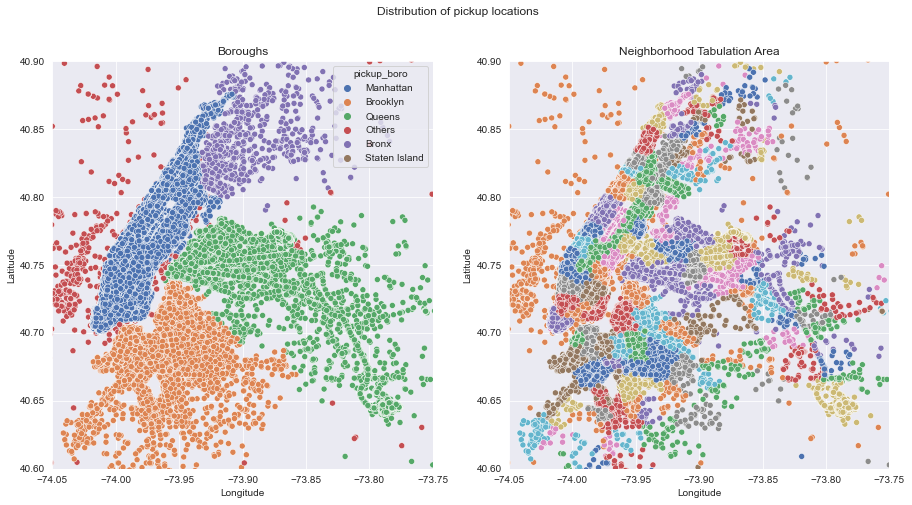

In [75]:
#plotting locations after removing outliers
city_long_border = (-74.05, -73.75)
city_lat_border = (40.60, 40.90)
plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of pickup locations')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = train_data,x='pickup_longitude',y='pickup_latitude',hue='pickup_boro',palette="deep",legend='auto')
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Boroughs",xlabel="Longitude",ylabel="Latitude")

plt.subplot(1,2,2)
fig = sb.scatterplot(data = train_data,x='pickup_longitude',y='pickup_latitude',hue='pickup_nta',palette="deep",legend=False)
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Neighborhood Tabulation Area",xlabel="Longitude",ylabel="Latitude")

plt.show()

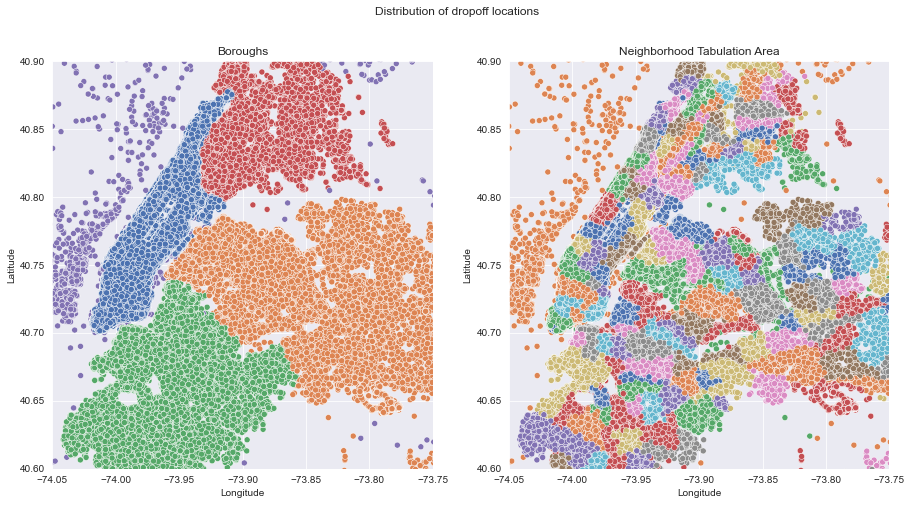

In [73]:
#plotting locations after removing outliers
city_long_border = (-74.05, -73.75)
city_lat_border = (40.60, 40.90)
plt.figure(figsize=(15,7.5))
plt.suptitle('Distribution of dropoff locations')
plt.subplot(1,2,1)
fig = sb.scatterplot(data = train_data,x='dropoff_longitude',y='dropoff_latitude',hue='dropoff_boro',palette="deep",legend=False)
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Boroughs",xlabel="Longitude",ylabel="Latitude")

plt.subplot(1,2,2)
fig = sb.scatterplot(data = train_data,x='dropoff_longitude',y='dropoff_latitude',hue='dropoff_nta',palette="deep",legend=False)
fig.set(xlim=city_long_border,ylim=city_lat_border,title="Neighborhood Tabulation Area",xlabel="Longitude",ylabel="Latitude")

plt.show()

In [97]:
m2q = train_data.query("(pickup_boro=='Manhattan') and (dropoff_boro=='Queens')")
q2m = train_data.query("(pickup_boro=='Queens') and (dropoff_boro=='Manhattan')")
m2m = train_data.query("(pickup_boro=='Manhattan') and (dropoff_boro=='Manhattan')")
q2q = train_data.query("(pickup_boro=='Queens') and (dropoff_boro=='Queens')")

## Manhattan to Queens trip details

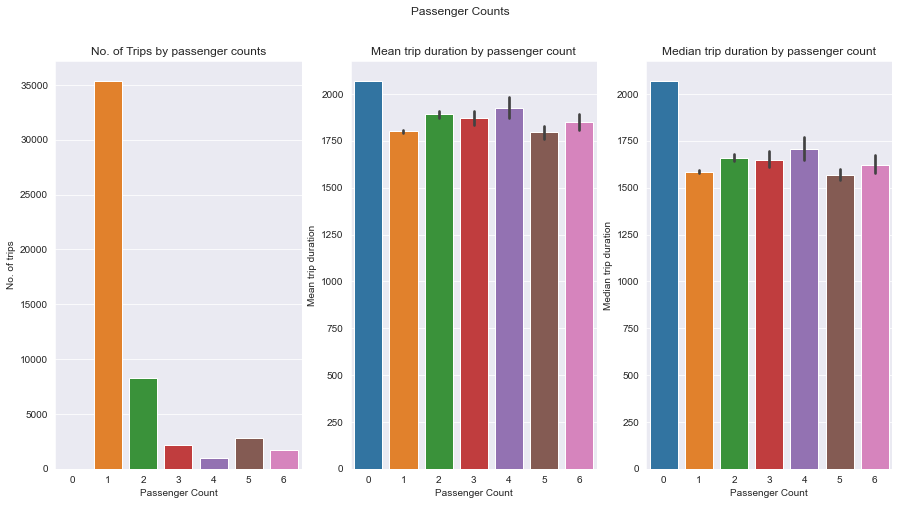

In [91]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Manhattan to Queens trip details')
plt.subplot(1,3,1)
fig = sb.countplot(x = m2q['passenger_count'])
fig.set(title = "No. of Trips by passenger counts",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = m2q['passenger_count'],y=m2q['trip_duration'],estimator=np.mean)
fig.set(title = "Mean trip duration by passenger count",xlabel='Passenger Count', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = m2q['passenger_count'],y=m2q['trip_duration'],estimator=np.median)
fig.set(title = "Median trip duration by passenger count",xlabel='Passenger Count', ylabel='Median trip duration')
plt.show()

### Observation:

1) Majority of the trips by 1 passenger

2) Mean trip duration ranges from 1750 - 2000 seconds

3) Median trip duration ranges from 1500 - 1750 seconds

## Queens to Manhattan trip details

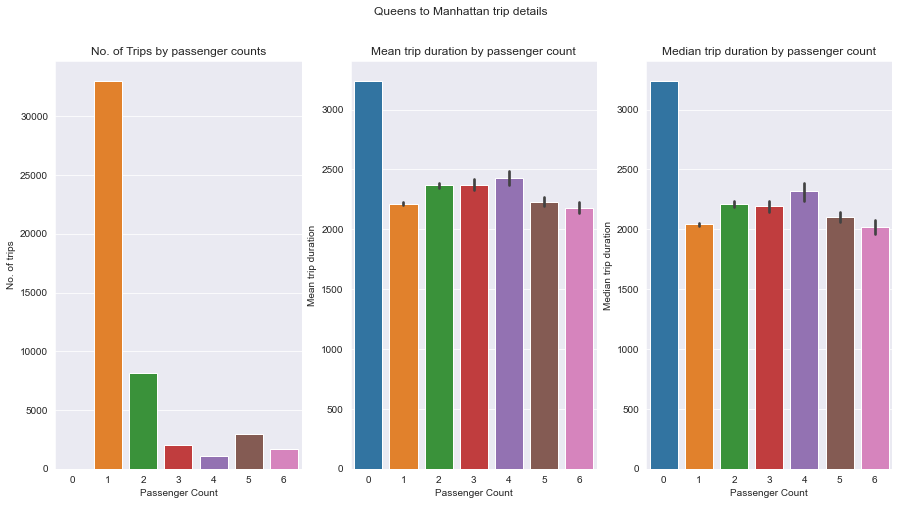

In [93]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Queens to Manhattan trip details')
plt.subplot(1,3,1)
fig = sb.countplot(x = q2m['passenger_count'])
fig.set(title = "No. of Trips by passenger counts",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = q2m['passenger_count'],y=q2m['trip_duration'],estimator=np.mean)
fig.set(title = "Mean trip duration by passenger count",xlabel='Passenger Count', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = q2m['passenger_count'],y=q2m['trip_duration'],estimator=np.median)
fig.set(title = "Median trip duration by passenger count",xlabel='Passenger Count', ylabel='Median trip duration')
plt.show()

### Observation:

1) Majority of the trips by 1 passenger

2) Mean and median trip duration ranges from 2000 - 2500 seconds

Trips from Queens to Manhattan, take longer time than Manhattan to Queens 

## Intra-Manhattan trip details

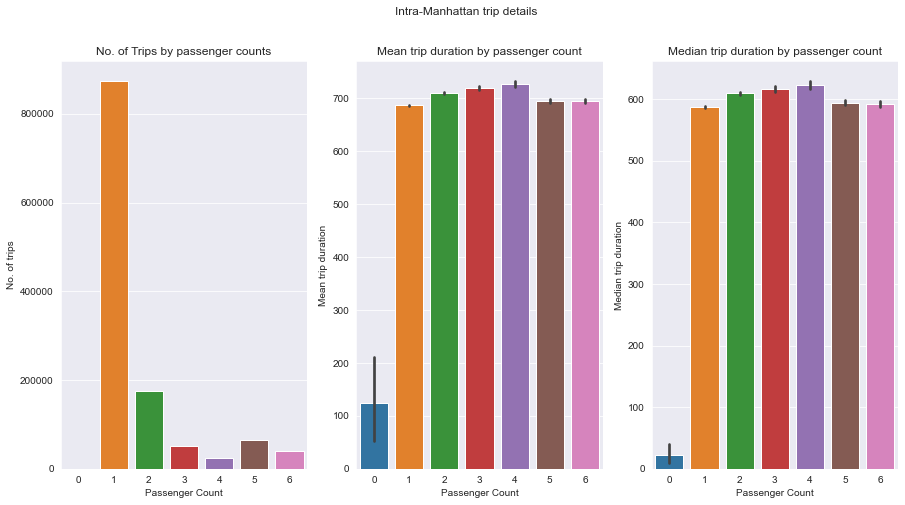

In [98]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Intra-Manhattan trip details')
plt.subplot(1,3,1)
fig = sb.countplot(x = m2m['passenger_count'])
fig.set(title = "No. of Trips by passenger counts",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = m2m['passenger_count'],y=m2m['trip_duration'],estimator=np.mean)
fig.set(title = "Mean trip duration by passenger count",xlabel='Passenger Count', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = m2m['passenger_count'],y=m2m['trip_duration'],estimator=np.median)
fig.set(title = "Median trip duration by passenger count",xlabel='Passenger Count', ylabel='Median trip duration')
plt.show()

## Intra-Queens trip details

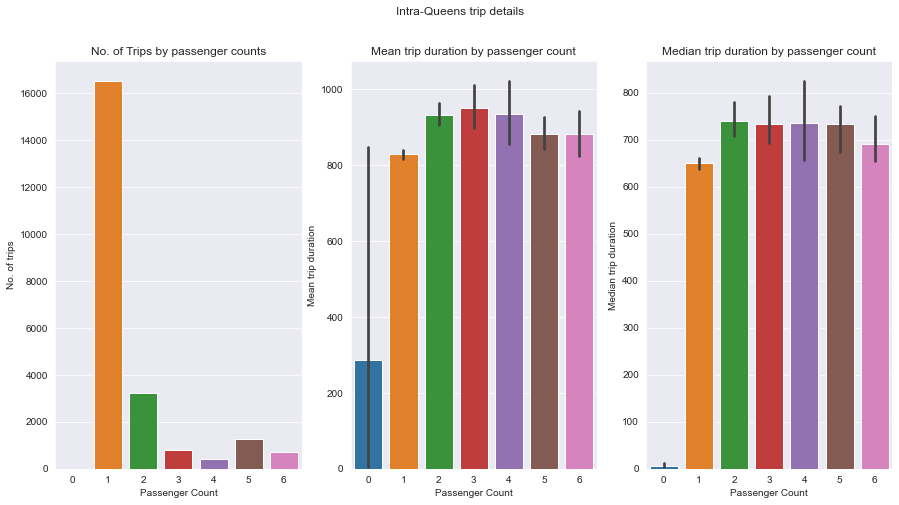

In [99]:
plt.figure(figsize=(15,7.5))
plt.suptitle('Intra-Queens trip details')
plt.subplot(1,3,1)
fig = sb.countplot(x = q2q['passenger_count'])
fig.set(title = "No. of Trips by passenger counts",xlabel='Passenger Count',ylabel='No. of trips')

plt.subplot(1,3,2)
fig = sb.barplot(x = q2q['passenger_count'],y=q2q['trip_duration'],estimator=np.mean)
fig.set(title = "Mean trip duration by passenger count",xlabel='Passenger Count', ylabel='Mean trip duration')

plt.subplot(1,3,3)
fig = sb.barplot(x = q2q['passenger_count'],y=q2q['trip_duration'],estimator=np.median)
fig.set(title = "Median trip duration by passenger count",xlabel='Passenger Count', ylabel='Median trip duration')
plt.show()

### Observation:

The median trip durations within Queens is ~700 seconds and within Manhattan is ~600 seconds

# 3. Modelling

In [2]:
data = pd.read_csv('C:/Users/ISR1/Documents/nyc/preprocessed_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456535 entries, 0 to 1456534
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1456535 non-null  int64  
 1   passenger_count     1456535 non-null  int64  
 2   pickup_longitude    1456535 non-null  float64
 3   pickup_latitude     1456535 non-null  float64
 4   dropoff_longitude   1456535 non-null  float64
 5   dropoff_latitude    1456535 non-null  float64
 6   store_and_fwd_flag  1456535 non-null  object 
 7   trip_duration       1456535 non-null  int64  
 8   pickup_hour         1456535 non-null  int64  
 9   pickup_day          1456535 non-null  int64  
 10  pickup_day_of_week  1456535 non-null  int64  
 11  pickup_month        1456535 non-null  int64  
 12  pickup_weekyear     1456535 non-null  int64  
 13  haversine_dist      1456535 non-null  float64
 14  bearing_dist        1456535 non-null  float64
 15  geodesic_dist  

In [4]:
data.head(5)

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                  N            455   
1         -73.999481         40.731152                  N            663   
2         -74.005333         40.710087                  N           2124   
3         -74.012268         40.706718                  N            429   
4         -73.972923         40.782520                  N            435   

   pickup_hour  pickup_day  ...   cosine_dist  braycurtis_dist  pickup_boro  \
0           17          14  ...  2.883154e-09         0.000087    Manhattan   
1            0          12  ...  1.725008e-08         0.000115    Manhattan   
2           11          19  ...  2.511432e-07         0.000349    Manhattan   
3           19           6  ...  1.127590e-08         0.000067    Manhattan   
4           13          26  ...  6.057234e-09         0.000047    Manhattan   

   pickup_nta  dropoff_boro  dropoff_nta  pickup_pop  pickup_area  \
0        MN14     Manhattan         MN40     61489.0     1.468418   
1        MN20     Manhattan         MN23     50742.0     1.343321   
2        MN17     Manhattan         MN25     28630.0     2.804861   
3        MN24     Manhattan         MN25     42742.0     2.325612   
4        MN12     Manhattan         MN12    132378.0     3.194001   

   dropoff_pop  dropoff_area  
0      61207.0      1.864133  
1      66880.0      2.312020  
2      39699.0      1.766242  
3      39699.0      1.766242  
4     132378.0      3.194001  

[5 rows x 31 columns]

In [194]:
print(train_data['pickup_area'].isna().sum())
print(train_data['dropoff_area'].isna().sum())
print(train_data['pickup_pop'].isna().sum())
print(train_data['dropoff_pop'].isna().sum())

0
0
0
0


In [195]:
print(test_data['pickup_area'].isna().sum())
print(test_data['dropoff_area'].isna().sum())
print(test_data['pickup_pop'].isna().sum())
print(test_data['dropoff_pop'].isna().sum())

0
0
0
0


### Checking for columns with same pickup and dropoff locations

In [196]:
print(len(np.where((train_data['pickup_latitude']==train_data['dropoff_latitude']) 
                   & (train_data['pickup_longitude']==train_data['dropoff_longitude']))[0]))

print(len(np.where((test_data['pickup_latitude']==test_data['dropoff_latitude']) 
                   & (test_data['pickup_longitude']==test_data['dropoff_longitude']))[0]))

5876
2464


### Converting datatype to category

In [161]:
categorical_features = ['passenger_count','vendor_id','store_and_fwd_flag','pickup_day','pickup_month','pickup_hour','pickup_weekyear','pickup_day_of_week','pickup_boro','pickup_nta','dropoff_boro','dropoff_nta']
for i in categorical_features:
    train_data[i]=train_data[i].astype('category')
    test_data[i]=test_data[i].astype('category')

### Imputation of NTA population and NTA area columns using KNN

In [162]:
g = train_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values
h = test_data[['pickup_area','pickup_pop','dropoff_area','dropoff_pop']].values

In [163]:
g

array([[1.46841753e+00, 6.14890000e+04, 1.86413329e+00, 6.12070000e+04],
       [1.34332119e+00, 5.07420000e+04, 2.31202038e+00, 6.68800000e+04],
       [2.80486147e+00, 2.86300000e+04, 1.76624220e+00, 3.96990000e+04],
       ...,
       [1.99821578e+00, 8.07710000e+04, 1.76624220e+00, 3.96990000e+04],
       [1.34332119e+00, 5.07420000e+04, 2.80486147e+00, 2.86300000e+04],
       [3.19400117e+00, 1.32378000e+05, 3.19400117e+00, 1.32378000e+05]])

In [164]:
import time
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)


st = time.time()
new_train_data = knn_imputer.fit_transform(g)
new_test_data = knn_imputer.transform(h)
et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 1746.050294160843 seconds


In [173]:
new_train_data

array([[1.46841753e+00, 6.14890000e+04, 1.86413329e+00, 6.12070000e+04],
       [1.34332119e+00, 5.07420000e+04, 2.31202038e+00, 6.68800000e+04],
       [2.80486147e+00, 2.86300000e+04, 1.76624220e+00, 3.96990000e+04],
       ...,
       [1.99821578e+00, 8.07710000e+04, 1.76624220e+00, 3.96990000e+04],
       [1.34332119e+00, 5.07420000e+04, 2.80486147e+00, 2.86300000e+04],
       [3.19400117e+00, 1.32378000e+05, 3.19400117e+00, 1.32378000e+05]])

In [174]:
new_test_data

array([[1.01210825e+00, 4.41360000e+04, 2.80486147e+00, 2.86300000e+04],
       [9.50721630e-01, 1.98490000e+04, 2.93937609e+00, 6.74590000e+04],
       [2.31202038e+00, 6.68800000e+04, 1.01210825e+00, 4.41360000e+04],
       ...,
       [2.80486147e+00, 2.86300000e+04, 4.44643781e+00, 1.08152000e+05],
       [5.17986778e-01, 2.10490000e+04, 3.37010865e+00, 6.13210000e+04],
       [2.16460342e+00, 7.29570000e+04, 8.49916211e+00, 1.84900000e+03]])

In [175]:
train_data['pickup_area'] = new_train_data[::,0]
train_data['pickup_pop'] = new_train_data[::,1]
train_data['dropoff_area'] = new_train_data[::,2]
train_data['dropoff_pop'] = new_train_data[::,3]

In [178]:
print(train_data['dropoff_area'].isna().sum())
print(train_data['dropoff_pop'].isna().sum())
print(train_data['pickup_area'].isna().sum())
print(train_data['pickup_pop'].isna().sum())

0
0
0
0


In [177]:
test_data['pickup_area'] = new_test_data[::,0]
test_data['pickup_pop'] = new_test_data[::,1]
test_data['dropoff_area'] = new_test_data[::,2]
test_data['dropoff_pop'] = new_test_data[::,3]

In [179]:
print(test_data['dropoff_area'].isna().sum())
print(test_data['dropoff_pop'].isna().sum())
print(test_data['pickup_area'].isna().sum())
print(test_data['pickup_pop'].isna().sum())

0
0
0
0


In [201]:
train_data.head(3)

vendor_id passenger_count  pickup_longitude  pickup_latitude  \
0         2               1        -73.982155        40.767937   
1         1               1        -73.980415        40.738564   
2         2               1        -73.979027        40.763939   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                  N            455   
1         -73.999481         40.731152                  N            663   
2         -74.005333         40.710087                  N           2124   

  pickup_hour pickup_day  ...   cosine_dist braycurtis_dist pickup_boro  \
0          17         14  ...  2.883154e-09        0.000087   Manhattan   
1           0         12  ...  1.725008e-08        0.000115   Manhattan   
2          11         19  ...  2.511432e-07        0.000349   Manhattan   

   pickup_nta  dropoff_boro  dropoff_nta  pickup_pop  pickup_area  \
0        MN14     Manhattan         MN40     61489.0     1.468418   
1        MN20     Manhattan         MN23     50742.0     1.343321   
2        MN17     Manhattan         MN25     28630.0     2.804861   

   dropoff_pop  dropoff_area  
0      61207.0      1.864133  
1      66880.0      2.312020  
2      39699.0      1.766242  

[3 rows x 31 columns]

In [200]:
test_data.head(3)

vendor_id passenger_count  pickup_longitude  pickup_latitude  \
0         1               1        -73.988129        40.732029   
1         1               1        -73.964203        40.679993   
2         1               1        -73.997437        40.737583   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag pickup_hour  \
0         -73.990173         40.756680                  N          23   
1         -73.959808         40.655403                  N          23   
2         -73.986160         40.729523                  N          23   

  pickup_day pickup_day_of_week  ...   cosine_dist braycurtis_dist  \
0         30                  3  ...  2.883154e-09        0.000087   
1         30                  3  ...  1.725008e-08        0.000115   
2         30                  3  ...  2.511432e-07        0.000349   

   pickup_boro  pickup_nta  dropoff_boro  dropoff_nta  pickup_pop  \
0    Manhattan        MN22     Manhattan         MN17     44136.0   
1     Brooklyn        BK64      Brooklyn         BK60     19849.0   
2    Manhattan        MN23     Manhattan         MN22     66880.0   

   pickup_area  dropoff_pop  dropoff_area  
0     1.012108      28630.0      2.804861  
1     0.950722      67459.0      2.939376  
2     2.312020      44136.0      1.012108  

[3 rows x 30 columns]

In [24]:
len(data.columns)

31

In [202]:
train_data.to_csv('train_data.csv',index=False)
test_data.to_csv('test_data.csv',index=False)

### Converting Categorical to numerical features using OHE

In [180]:
one_hot_encoded_train_data = pd.get_dummies(train_data, columns = categorical_features)
one_hot_encoded_test_data = pd.get_dummies(test_data, columns = categorical_features)

In [181]:
one_hot_encoded_train_data.head(3)

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   

   trip_duration  haversine_dist  bearing_dist  geodesic_dist  euclidean_dist  \
0            455        1.498521     99.970196       1.502172        0.017680   
1            663        1.805507   -117.153768       1.808660        0.020456   
2           2124        6.385098   -159.680165       6.379687        0.059934   

   manhattan_dist  ...  dropoff_nta_SI24  dropoff_nta_SI25  dropoff_nta_SI28  \
0        0.019859  ...                 0                 0                 0   
1        0.026478  ...                 0                 0                 0   
2        0.080158  ...                 0                 0                 0   

   dropoff_nta_SI32  dropoff_nta_SI35  dropoff_nta_SI36  dropoff_nta_SI37  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   dropoff_nta_SI45  dropoff_nta_SI48  dropoff_nta_SI54  
0                 0                 0                 0  
1                 0                 0                 0  
2                 0                 0                 0  

[3 rows x 524 columns]

In [182]:
one_hot_encoded_test_data.head(3)

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   

   haversine_dist  bearing_dist  geodesic_dist  euclidean_dist  \
0        2.746426     -3.595224       1.502172        0.017680   
1        2.759239    172.278835       1.808660        0.020456   
2        1.306155    133.326248       6.379687        0.059934   

   manhattan_dist  chebyshev_dist  ...  dropoff_nta_SI24  dropoff_nta_SI25  \
0        0.019859        0.017525  ...                 0                 0   
1        0.026478        0.019066  ...                 0                 0   
2        0.080158        0.053852  ...                 0                 0   

   dropoff_nta_SI28  dropoff_nta_SI32  dropoff_nta_SI35  dropoff_nta_SI36  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   dropoff_nta_SI37  dropoff_nta_SI45  dropoff_nta_SI48  dropoff_nta_SI54  
0                 0                 0                 0                 0  
1                 0                 0                 0                 0  
2                 0                 0                 0                 0  

[3 rows x 511 columns]

In [27]:
one_hot_encoded_data.to_csv('preprocessed_ohe_data.csv',index=False)

In [28]:
one_hot_encoded_data = pd.read_csv('preprocessed_ohe_data.csv')

In [185]:
A = set(one_hot_encoded_train_data.columns.values)
B = set(one_hot_encoded_test_data.columns.values)

In [186]:
A-B

{'dropoff_nta_BX98',
 'passenger_count_7',
 'passenger_count_8',
 'pickup_nta_BK23',
 'pickup_nta_BX31',
 'pickup_nta_BX98',
 'pickup_nta_QN23',
 'pickup_nta_QN33',
 'pickup_nta_QN66',
 'pickup_nta_SI01',
 'pickup_nta_SI12',
 'pickup_nta_SI28',
 'pickup_nta_SI32',
 'pickup_nta_SI54',
 'trip_duration'}

In [30]:
one_hot_encoded_data.isna().sum()

pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
trip_duration        0
                    ..
dropoff_nta_SI36     0
dropoff_nta_SI37     0
dropoff_nta_SI45     0
dropoff_nta_SI48     0
dropoff_nta_SI54     0
Length: 515, dtype: int64

In [31]:
len(one_hot_encoded_data.columns)

515

In [32]:
X = one_hot_encoded_data.drop(['trip_duration'],axis=1)

In [33]:
X.columns.values

array(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'haversine_dist', 'bearing_dist',
       'geodesic_dist', 'euclidean_dist', 'manhattan_dist',
       'chebyshev_dist', 'canberra_dist', 'sqeuclidean_dist',
       'cosine_dist', 'braycurtis_dist', 'pickup_pop', 'pickup_area',
       'dropoff_pop', 'dropoff_area', 'passenger_count_0',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'passenger_count_7', 'passenger_count_8', 'vendor_id_1',
       'vendor_id_2', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'pickup_day_1', 'pickup_day_2', 'pickup_day_3', 'pickup_day_4',
       'pickup_day_5', 'pickup_day_6', 'pickup_day_7', 'pickup_day_8',
       'pickup_day_9', 'pickup_day_10', 'pickup_day_11', 'pickup_day_12',
       'pickup_day_13', 'pickup_day_14', 'pickup_day_15', 'pickup_day_16',
       'pickup_day_17', 'pickup_day_18', 'pickup_day_19'

In [34]:
X = X.values

In [35]:
X[0]

array([-7.39821548e+01,  4.07679367e+01, -7.39646301e+01,  4.07656021e+01,
        1.49852078e+00,  9.99701956e+01,  1.50217184e+00,  1.76795395e-02,
        1.98593140e-02,  1.75247192e-02,  1.47086407e-04,  3.12566117e-04,
        2.88315360e-09,  8.65403780e-05,  6.14890000e+04,  1.46841753e+00,
        6.12070000e+04,  1.86413329e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [36]:
y = one_hot_encoded_data['trip_duration'].values

In [37]:
y[0]

455

### Feature Scaling using StandardScaler

In [38]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
new_X = ss.fit_transform(X)

In [39]:
new_X.shape

(1450659, 514)

In [40]:
from scipy import sparse
newer_X = sparse.csr_matrix(new_X)

In [30]:
newer_X

<1450659x514 sparse matrix of type '<class 'numpy.float64'>'
	with 745638726 stored elements in Compressed Sparse Row format>

### Linear Regression

In [93]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [103]:
linear = LinearRegression(n_jobs=-1)
st = time.time()
linear.fit(newer_X, np.log(y+1))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 540.9714753627777 seconds


In [104]:
linear.score(newer_X,np.log(y+1)) #with the population and area columns - new

0.6053438168833319

In [105]:
linear_prediction = linear.predict(newer_X)

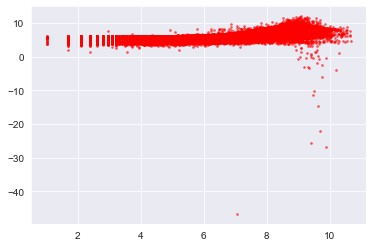

In [118]:
plt.scatter(np.log(y+1), linear_prediction, s=3, color='red', alpha=0.5)
plt.show()

### Ridge Regression

In [137]:
ridge = Ridge(alpha = 10)
st = time.time()
ridge.fit(newer_X, np.log(y+1))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 130.82857990264893 seconds


In [138]:
ridge.score(newer_X,np.log(y+1))

0.6053328722001812

In [139]:
ridge_prediction = ridge.predict(newer_X)
#ridge_prediction = np.exp(ridge_prediction) - 1

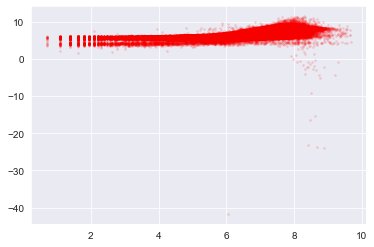

In [140]:
plt.scatter(np.log(y+1), ridge_prediction, s=3, color='red', alpha=0.1)
plt.show()

### Lasso Regression

In [48]:
lasso = Lasso(alpha = 0.1)
st = time.time()
lasso.fit(newer_X, y)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 5804.26725769043 seconds


D:\Anaconda3\envs\new-gpu-spatial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41101164371.337845, tolerance: 63446110.677454494
  model = cd_fast.sparse_enet_coordinate_descent(


In [49]:
lasso_prediction = lasso.predict(newer_X)

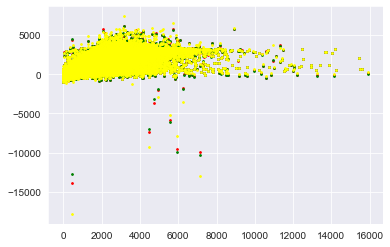

In [52]:
plt.scatter(y, lasso_prediction, s=3, color='green')
plt.show()

In [49]:
print(mean_squared_error(y,prediction))
print(mean_absolute_error(y,prediction))
#print(mean_squared_log_error(y,prediction))
#print(mean_squared_log_error(y,prediction),squared=True)

480422.0375101143
273.56508528358944


### Decision Tree Regression

In [141]:
dt_model = DecisionTreeRegressor(criterion="mse", max_depth=10)
st = time.time()
dt_model.fit(newer_X, np.log(y+1))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
dt_pred = dt_model.predict(newer_X)

Execution time: 877.9765939712524 seconds


In [142]:
dt_model.score(new_X,np.log(y+1))

0.7144395788224086

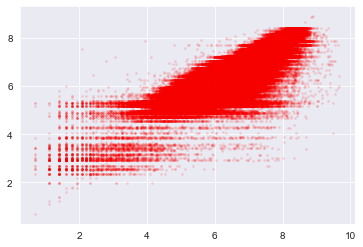

In [143]:
plt.scatter(np.log(y+1), dt_pred, s=3, color='red', alpha=0.1)
plt.show()

In [144]:
print(mean_squared_error(np.log(y)+1,dt_pred))
print(mean_absolute_error(np.log(y)+1,dt_pred))
print(mean_squared_log_error(np.log(y)+1,dt_pred))

1.163548659238605
1.0037336743767988
0.0183984360518195


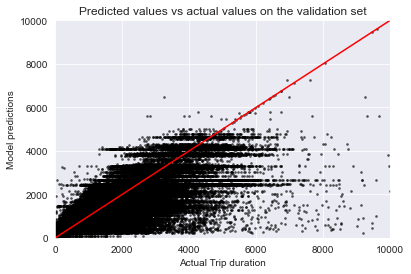

In [40]:
plt.scatter(y, dt_pred, s=3, color='black', alpha=0.5)
plt.plot([1,10000],[1,10000], color='red')
plt.title('Predicted values vs actual values on the validation set')
plt.xlabel('Actual Trip duration')
plt.ylabel('Model predictions')
axes = plt.gca()
axes.set_xlim([0, 10000])
axes.set_ylim([0, 10000])
plt.show()

### Random Forest Regression

In [128]:
rf_model = RandomForestRegressor(n_jobs = -1, random_state = 42)
st = time.time()
rf_model.fit(new_X, np.log(y+1))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 1531.2317202091217 seconds


In [129]:
rf_model.score(new_X,np.log(y+1))

-0.7249357524184148

In [ ]:
rf_prediction = rf_model.predict(new_X)

In [ ]:
plt.scatter(np.log(y+1), rf_prediction, s=3, color='red', alpha=0.1)
plt.show()

In [ ]:
print(mean_squared_error(np.log(y),prediction2))
print(mean_absolute_error(np.log(y),prediction2))

### Extreme Gradient Boosting Regression

In [131]:
np.log(y)+1

array([7.12029742, 7.49677499, 8.66105638, ..., 7.63856779, 6.92157842,
       6.28826703])

In [133]:
np.log(y+1)

array([6.12029742, 6.49677499, 7.66105638, ..., 6.63856779, 5.92157842,
       5.28826703])

In [130]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1)
st = time.time()
xgb_model.fit(new_X, np.log(y+1))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 2780.343231201172 seconds


In [134]:
xgb_model.score(new_X,np.log(y+1))

-0.8539433988924461

In [135]:
xgb_prediction = xgb_model.predict(new_X)

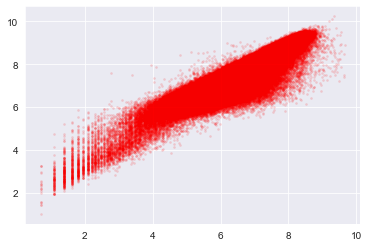

In [136]:
plt.scatter(np.log(y+1), xgb_prediction, s=3, color='red', alpha=0.1)
plt.show()

# Reference

1) https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

2) https://gis.stackexchange.com/a/301285

3) https://geopandas.org/en/v0.9.0/gallery/spatial_joins.html

4) https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2/data

5) https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

6) https://geopandas.org/en/v0.9.0/docs/user_guide.html

7) https://stats.stackexchange.com/questions/462507/how-to-decide-whether-missing-values-are-mar-mcar-or-mnar

8) https://www.theanalysisfactor.com/missing-data-mechanism/

9) https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values

10) https://towardsdatascience.com/your-mcar-data-technique-guide-b13a06914ed6

11) https://stackoverflow.com/a/60454843